## Hourly Temperature Comparison for Control and Intervention Groups for Entire Time Period

This script generates detailed plots comparing hourly temperature variations for control and intervention groups between Rainbow Field and Sports Complex settlements, highlighting the differences before and after intervention.

- **Input Data:**
  - `master_dataframe.csv`: Contains temperature readings and timestamps.
  - `logger_flags.csv`: Metadata about loggers, including settlement, intervention type, and intervention start times.

- **Settlement and Intervention Filters:**
  - Filters loggers based on the selected settlement (e.g., "Rainbow Field") and intervention type (e.g., "MEB").
  - Identifies control and intervention loggers for comparison.

- **Post-Intervention Analysis:**
  - Computes hourly statistics (max, min, mean, standard deviation) for both control and intervention groups after the intervention start time.
  - Calculates hours elapsed since the intervention for alignment.

- **Visualization:**
  - Fills areas between max and min temperatures for control and intervention loggers.
  - Plots mean temperature trends for control (red) and intervention (blue).
  - Adds daily boxplots showing mean temperature distributions.

### User-Configurable Variables

- **`settlements`**: List of settlement names to analyze. You can add or remove settlements based on your dataset (e.g., `['Rainbow Field', 'Sports Complex']`).
- **`intervention_types`**: List of intervention types to analyze. Update this to include the specific interventions you want to compare (e.g., `['MEB', 'RBF']`).
- **`logger_flags_df` and `master_df`**: Input CSV files. Ensure these files are updated with the correct paths and content.

Produces detailed plots comparing temperature trends and ranges between control and intervention groups.

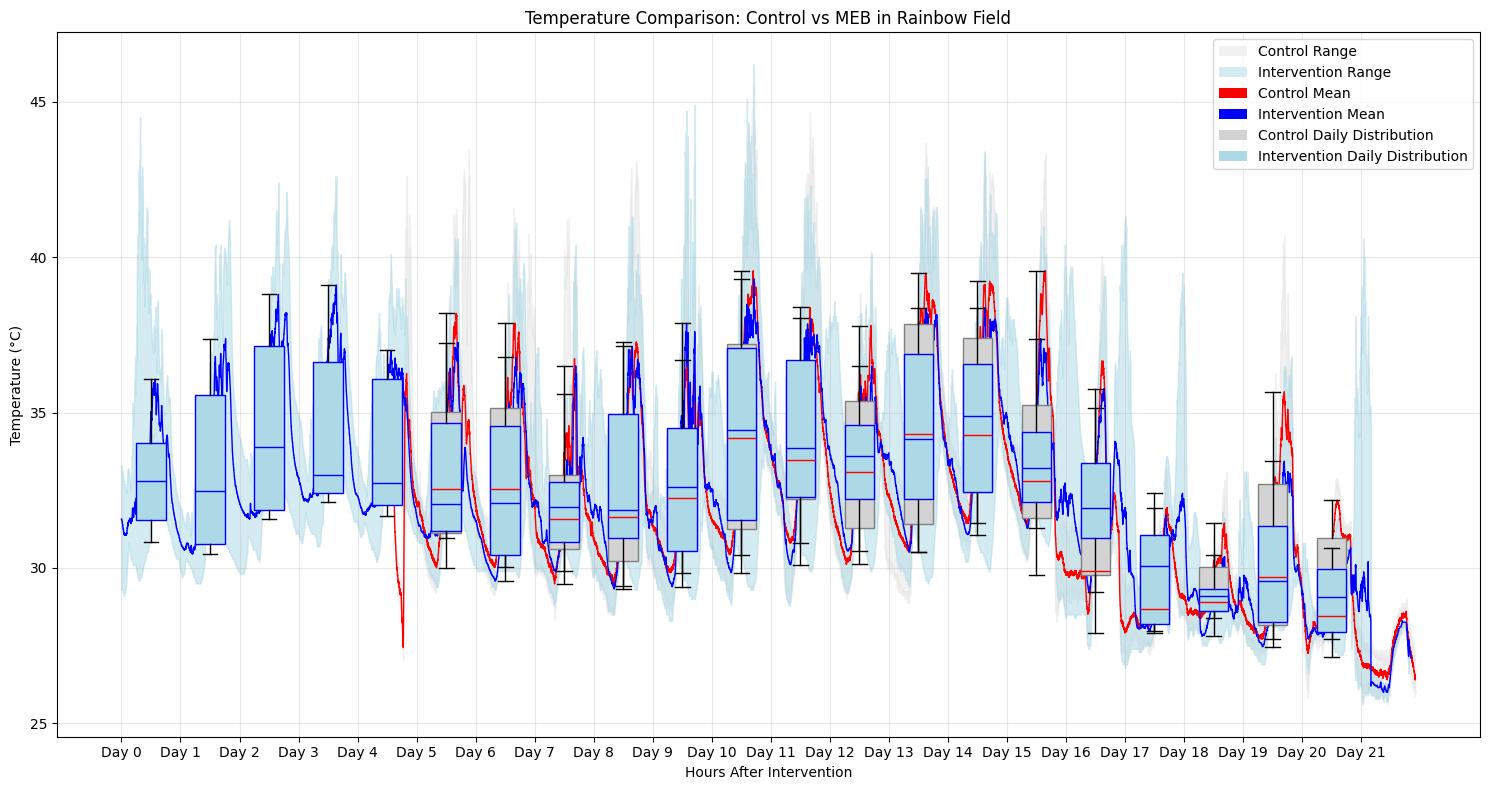

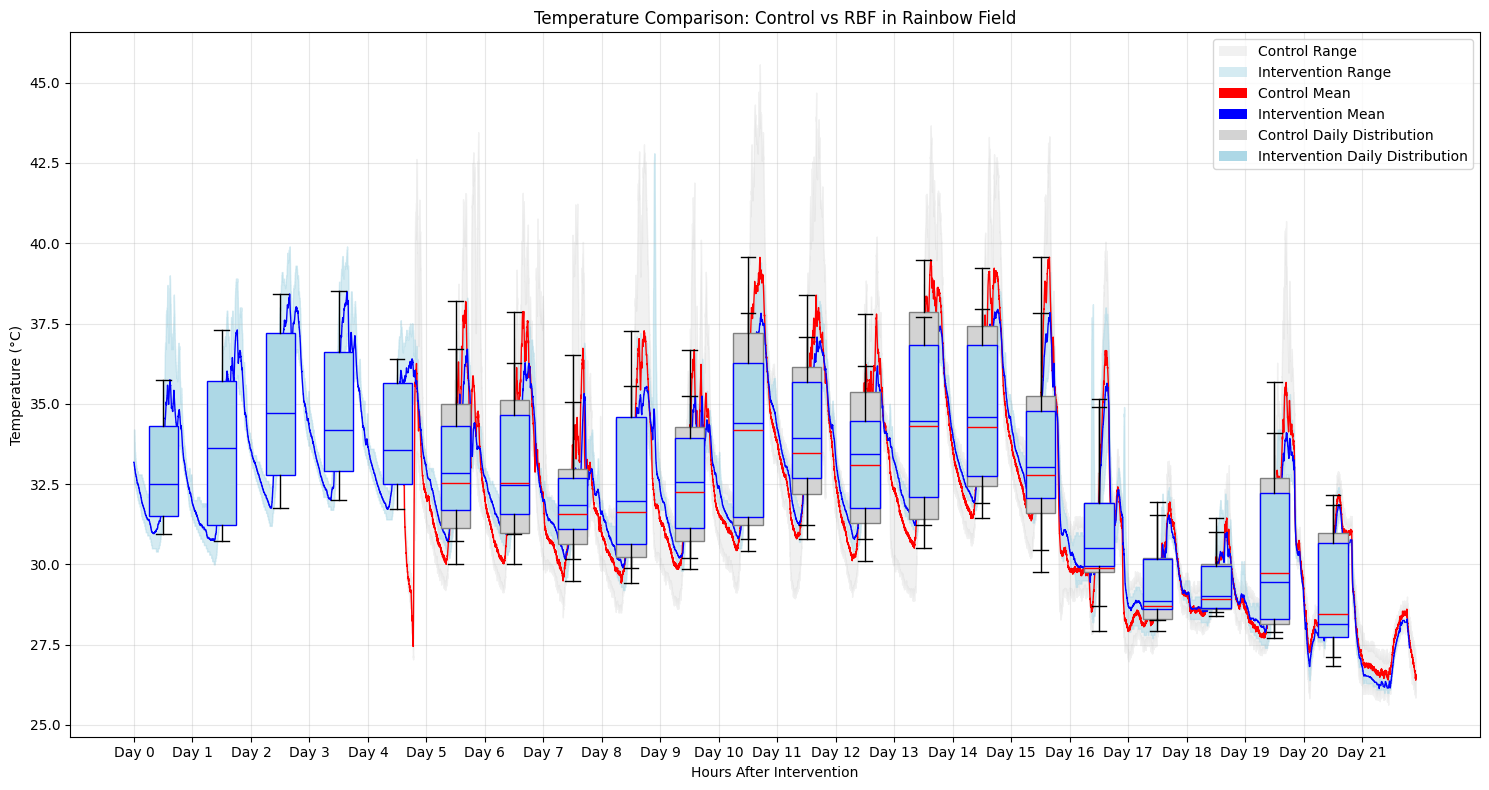

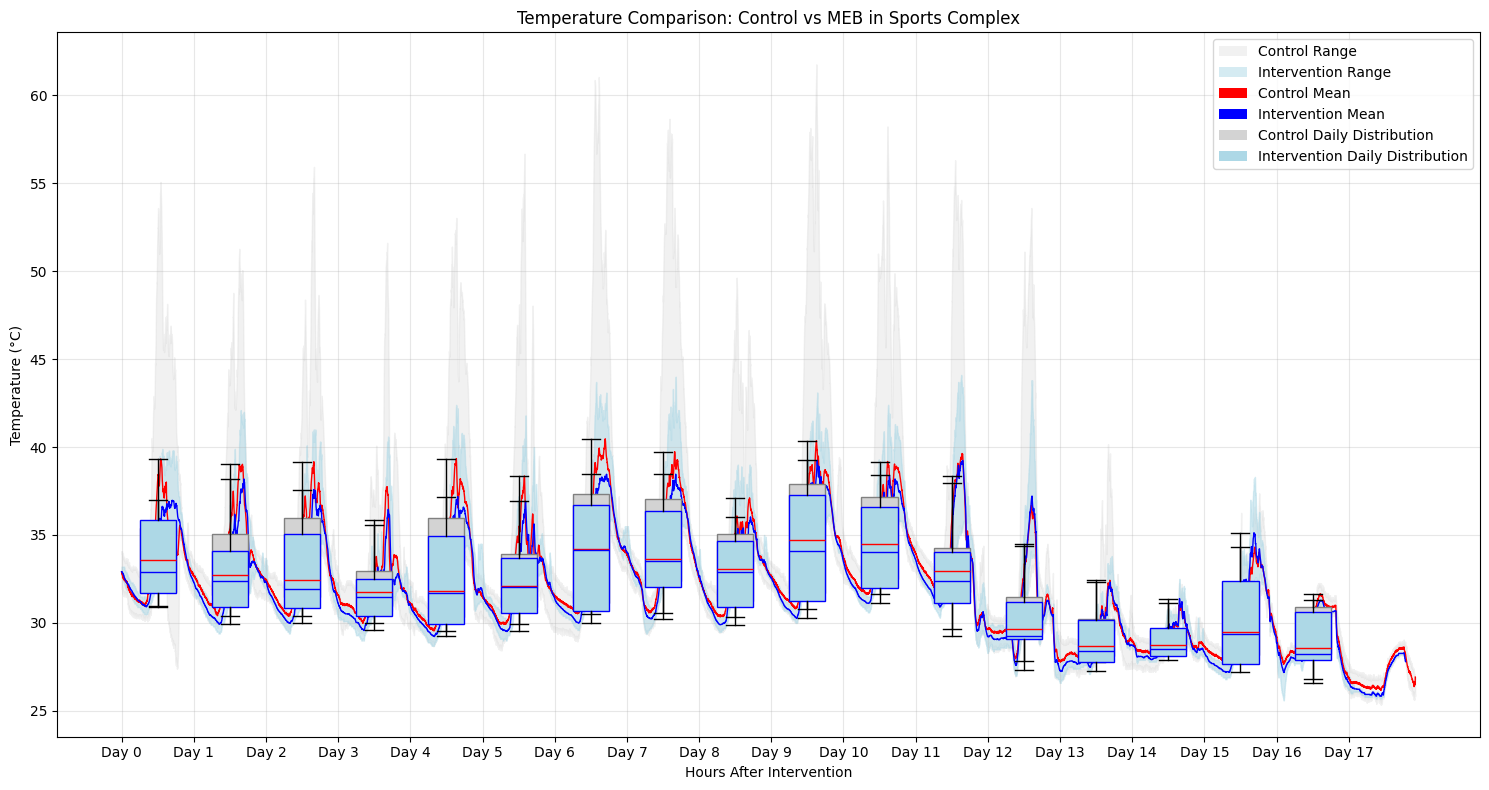

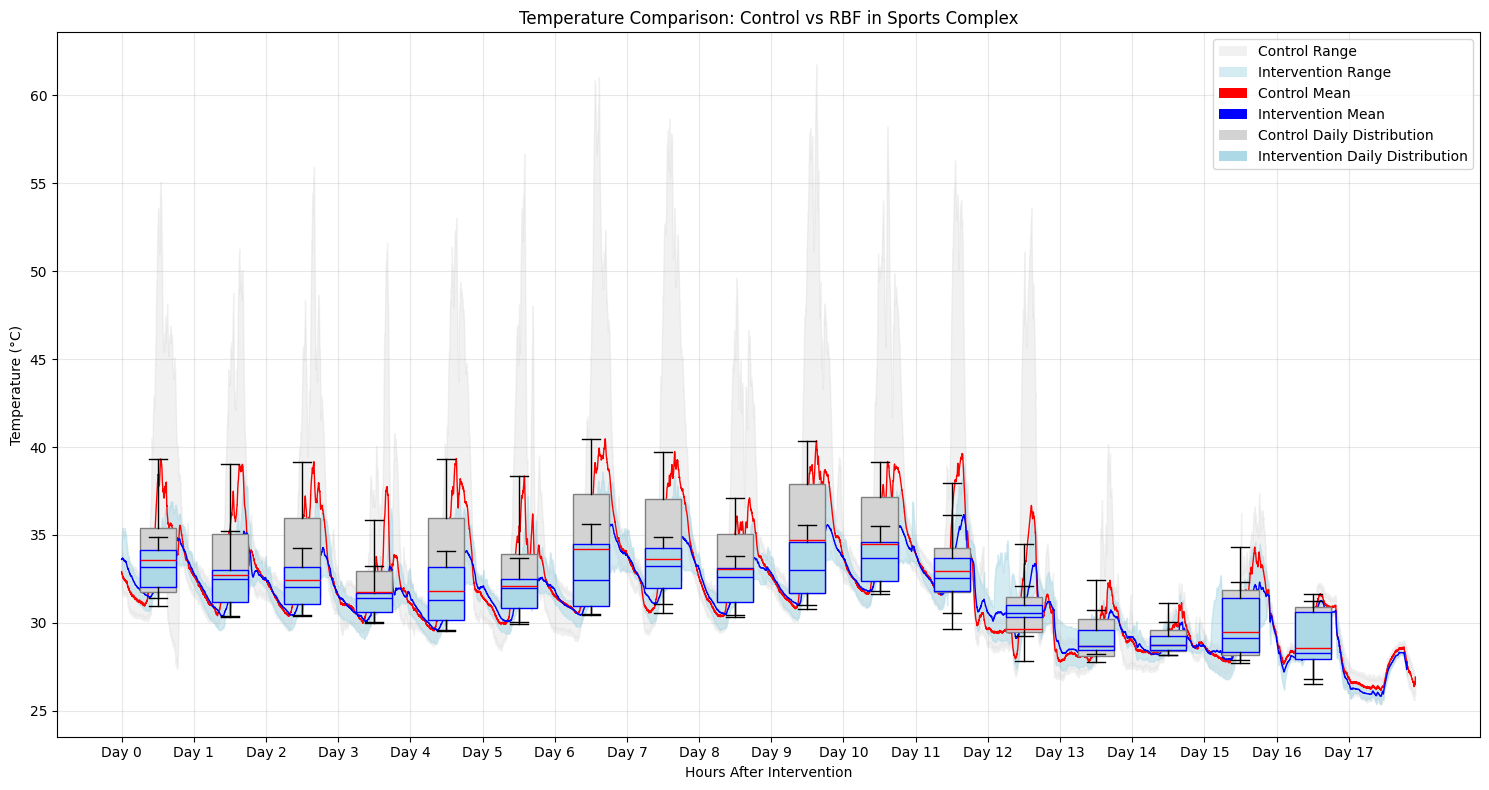

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

master_df = pd.read_csv('master_dataframe.csv', parse_dates=['DateTime'])
logger_flags_df = pd.read_csv('logger_flags.csv')

def create_hourly_comparison_plot(settlement, intervention_type='MEB'):
    control_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) &
        (logger_flags_df['Intervention'] == 'CONTROL')
    ]['Loggers'].tolist()

    intervention_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) &
        (logger_flags_df['Intervention'] == intervention_type)
    ]['Loggers'].tolist()

    intervention_start = pd.to_datetime(
        logger_flags_df[
            (logger_flags_df['Settlement'] == settlement) &
            (logger_flags_df['Intervention'] == intervention_type)
        ]['Intervention_Start'].iloc[0]
    )

    master_df['DateTime'] = pd.to_datetime(master_df['DateTime'])
    post_intervention_df = master_df[master_df['DateTime'] >= intervention_start].copy()
    post_intervention_df['Hours_After_Intervention'] = (
        post_intervention_df['DateTime'] - intervention_start
    ).dt.total_seconds() / 3600

    def calculate_hourly_stats(loggers, df):
        hourly_stats = pd.DataFrame()

        logger_data = df[loggers]
        hourly_stats['max'] = logger_data.max(axis=1)
        hourly_stats['min'] = logger_data.min(axis=1)
        hourly_stats['mean'] = logger_data.mean(axis=1)
        hourly_stats['std'] = logger_data.std(axis=1)
        hourly_stats['Hours_After_Intervention'] = df['Hours_After_Intervention']

        return hourly_stats

    control_stats = calculate_hourly_stats(control_loggers, post_intervention_df)
    intervention_stats = calculate_hourly_stats(intervention_loggers, post_intervention_df)

    plt.figure(figsize=(15, 8))

    plt.fill_between(control_stats['Hours_After_Intervention'],
                     control_stats['max'],
                     control_stats['min'],
                     alpha=0.3,
                     color='lightgray',
                     label='Control Range')

    plt.fill_between(intervention_stats['Hours_After_Intervention'],
                     intervention_stats['max'],
                     intervention_stats['min'],
                     alpha=0.5,
                     color='lightblue',
                     label='Intervention Range')

    plt.plot(control_stats['Hours_After_Intervention'],
             control_stats['mean'],
             color='red',
             label='Control Mean',
             linewidth=1)

    plt.plot(intervention_stats['Hours_After_Intervention'],
             intervention_stats['mean'],
             color='blue',
             label='Intervention Mean',
             linewidth=1)

    box_width = 12
    for day in range(int(max(control_stats['Hours_After_Intervention']) / 24)):
        hour = day * 24

        control_day = control_stats[
            (control_stats['Hours_After_Intervention'] >= hour) &
            (control_stats['Hours_After_Intervention'] < hour + 24)
        ]
        intervention_day = intervention_stats[
            (intervention_stats['Hours_After_Intervention'] >= hour) &
            (intervention_stats['Hours_After_Intervention'] < hour + 24)
        ]

        if len(control_day) > 0:
            plt.boxplot(control_day['mean'],
                       positions=[hour + 12],
                       widths=box_width,
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgray', color='gray'),
                       medianprops=dict(color='red'),
                       showfliers=False)

        if len(intervention_day) > 0:
            plt.boxplot(intervention_day['mean'],
                       positions=[hour + 12],
                       widths=box_width,
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', color='blue'),
                       medianprops=dict(color='blue'),
                       showfliers=False)

    plt.xlabel('Hours After Intervention')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Temperature Comparison: Control vs {intervention_type} in {settlement}')

    legend_elements = [
        Patch(facecolor='lightgray', alpha=0.3, label='Control Range'),
        Patch(facecolor='lightblue', alpha=0.5, label='Intervention Range'),
        Patch(facecolor='red', label='Control Mean'),
        Patch(facecolor='blue', label='Intervention Mean'),
        Patch(facecolor='lightgray', label='Control Daily Distribution'),
        Patch(facecolor='lightblue', label='Intervention Daily Distribution')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    xticks = np.arange(0, max(control_stats['Hours_After_Intervention']), 24)
    plt.xticks(xticks, [f'Day {int(x/24)}' for x in xticks])

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

settlements = ['Rainbow Field', 'Sports Complex']
intervention_types = ['MEB', 'RBF']

for settlement in settlements:
    for intervention_type in intervention_types:
        create_hourly_comparison_plot(settlement, intervention_type)

## Enhanced Hourly Temperature Comparison for Control and Intervention Groups

This script generates customizable plots comparing hourly temperature variations for control and intervention groups, incorporating flexible time grouping, settlement selection, and color schemes.

- Configurable time grouping for box plots (e.g., 2-hour, 6-hour, daily).
- Interactive legend to toggle plot elements (e.g., control/intervention ranges or means).
- Customizable color scheme for all plot elements.

- **Post-Intervention Analysis:**
  - Computes hourly statistics (max, min, mean, standard deviation) for control and intervention groups after the intervention start time.
  - Groups data by the specified hour distribution to create box plots.

### User-Configurable Variables

- **`settlements`**: List of settlement names to analyze. Update this to include or exclude settlements (e.g., `['Rainbow Field', 'Sports Complex']`).
- **`intervention_types`**: List of intervention types to analyze. Modify to include relevant interventions (e.g., `['MEB', 'RBF']`).
- **`hour_distribution`**: Controls the time grouping for box plots. Set to values like `2` (2-hour groups), `6` (6-hour groups), or `24` (daily groups).
- **`custom_colors`**: Dictionary for plot color customization. Update specific elements, such as:
  - `'control_range'`: Color for the control range (default: `'#E0E0E0'`).
  - `'intervention_mean'`: Color for the intervention mean line (default: `'#6495ED'`).
- **`logger_flags_df` and `master_df`**: Input CSV files. Ensure these paths and contents are correct.

### Instructions

1. Copy the above code into a new Python file, for example, `interactive_plot.py`.
2. Run the script to generate the plot.
3. Click on the legend items to hide or unhide the corresponding plot lines.

In [ ]:
import pandas as pd
import numpy.ma as ma
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

def create_hourly_comparison_plot(
    settlement, 
    intervention_type='MEB', 
    hour_distribution=2,
    colors=None
):
    """
    Create comparison plot with configurable hour distribution and colors for box plots
    
    Parameters:
    -----------
    settlement : str
        Name of the settlement
    intervention_type : str
        Type of intervention (default: 'MEB')
    hour_distribution : int
        Number of hours to group for each box plot (default: 2)
        Examples: 2 for 2-hour distribution, 6 for 6-hour, 24 for daily
    colors : dict, optional
        Dictionary to customize plot colors. Supports the following keys:
        - 'control_range': color for control range fill (default: 'lightgray')
        - 'intervention_range': color for intervention range fill (default: 'lightblue')
        - 'control_mean': color for control mean line (default: 'red')
        - 'intervention_mean': color for intervention mean line (default: 'blue')
        - 'control_box': color for control box (default: 'lightgray')
        - 'intervention_box': color for intervention box (default: 'lightblue')
    """
    default_colors = {
        'control_range': 'lightgray',
        'intervention_range': 'lightblue',
        'control_mean': 'red',
        'intervention_mean': 'blue',
        'control_box': 'lightgray',
        'intervention_box': 'lightblue'
    }
    
    if colors is not None:
        default_colors.update(colors)
    
    master_df = pd.read_csv('master_dataframe.csv', parse_dates=['DateTime'])
    logger_flags_df = pd.read_csv('logger_flags.csv')

    control_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) & 
        (logger_flags_df['Intervention'] == 'CONTROL')
    ]['Loggers'].tolist()
    
    intervention_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) & 
        (logger_flags_df['Intervention'] == intervention_type)
    ]['Loggers'].tolist()

    intervention_start = pd.to_datetime(
        logger_flags_df[
            (logger_flags_df['Settlement'] == settlement) & 
            (logger_flags_df['Intervention'] == intervention_type)
        ]['Intervention_Start'].iloc[0]
    )

    master_df['DateTime'] = pd.to_datetime(master_df['DateTime'])
    post_intervention_df = master_df[master_df['DateTime'] >= intervention_start].copy()
    post_intervention_df['Hours_After_Intervention'] = (
        post_intervention_df['DateTime'] - intervention_start
    ).dt.total_seconds() / 3600

    def calculate_hourly_stats(loggers, df):
        hourly_stats = pd.DataFrame()
        logger_data = df[loggers]
        hourly_stats['max'] = logger_data.max(axis=1)
        hourly_stats['min'] = logger_data.min(axis=1)
        hourly_stats['mean'] = logger_data.mean(axis=1)
        hourly_stats['std'] = logger_data.std(axis=1)
        hourly_stats['Hours_After_Intervention'] = df['Hours_After_Intervention']
        return hourly_stats

    control_stats = calculate_hourly_stats(control_loggers, post_intervention_df)
    intervention_stats = calculate_hourly_stats(intervention_loggers, post_intervention_df)

    fig, ax = plt.subplots(figsize=(15, 10))

    control_range = ax.fill_between(control_stats['Hours_After_Intervention'],
                                  control_stats['max'],
                                  control_stats['min'],
                                  alpha=0.3,
                                  color=default_colors['control_range'],
                                  label='Control Range')

    intervention_range = ax.fill_between(intervention_stats['Hours_After_Intervention'],
                                       intervention_stats['max'],
                                       intervention_stats['min'],
                                       alpha=0.5,
                                       color=default_colors['intervention_range'],
                                       label='Intervention Range')

    control_mean, = ax.plot(control_stats['Hours_After_Intervention'],
                          control_stats['mean'],
                          color=default_colors['control_mean'],
                          label='Control Mean',
                          linewidth=2)
    
    intervention_mean, = ax.plot(intervention_stats['Hours_After_Intervention'],
                               intervention_stats['mean'],
                               color=default_colors['intervention_mean'],
                               label='Intervention Mean',
                               linewidth=2)

    control_boxes = []
    intervention_boxes = []

    box_width = hour_distribution * 0.8
    max_hours = max(control_stats['Hours_After_Intervention'])
    
    for hour in np.arange(0, max_hours, hour_distribution):
        control_period = control_stats[
            (control_stats['Hours_After_Intervention'] >= hour) & 
            (control_stats['Hours_After_Intervention'] < hour + hour_distribution)
        ]
        intervention_period = intervention_stats[
            (intervention_stats['Hours_After_Intervention'] >= hour) & 
            (intervention_stats['Hours_After_Intervention'] < hour + hour_distribution)
        ]

        if len(control_period) > 0:
            control_box = ax.boxplot(control_period['mean'],
                                   positions=[hour + hour_distribution/2],
                                   widths=box_width,
                                   patch_artist=True,
                                   boxprops=dict(facecolor=default_colors['control_box'], color='gray'),
                                   medianprops=dict(color=default_colors['control_mean']),
                                   showfliers=False)
            control_boxes.append(control_box)
            
        if len(intervention_period) > 0:
            intervention_box = ax.boxplot(intervention_period['mean'],
                                        positions=[hour + hour_distribution/2],
                                        widths=box_width,
                                        patch_artist=True,
                                        boxprops=dict(facecolor=default_colors['intervention_box'], color='blue'),
                                        medianprops=dict(color=default_colors['intervention_mean']),
                                        showfliers=False)
            intervention_boxes.append(intervention_box)

    distribution_label = f'{hour_distribution}-Hour Distribution'
    legend_elements = [
        (Patch(facecolor=default_colors['control_range'], alpha=0.3), [control_range], 'Control Range'),
        (Patch(facecolor=default_colors['intervention_range'], alpha=0.5), [intervention_range], 'Intervention Range'),
        (Patch(facecolor=default_colors['control_mean']), [control_mean], 'Control Mean'),
        (Patch(facecolor=default_colors['intervention_mean']), [intervention_mean], 'Intervention Mean'),
        (Patch(facecolor=default_colors['control_box'], alpha=1.0), 
         control_boxes, 
         f'Control {distribution_label}'),
        (Patch(facecolor=default_colors['intervention_box'], alpha=1.0), 
         intervention_boxes, 
         f'Intervention {distribution_label}')
    ]

    leg = ax.legend([item[0] for item in legend_elements],
                   [item[2] for item in legend_elements],
                   loc='upper right')

    lined = {}
    for legpatch, elements, label in legend_elements:
        legline = leg.get_patches()[legend_elements.index((legpatch, elements, label))]
        if distribution_label in label:
            lined[legline] = elements
        else:
            lined[legline] = elements

    def on_pick(event):
        legline = event.artist
        if legline in lined:
            elements = lined[legline]
            
            if isinstance(elements[0], dict): 
                visible = not any(box['boxes'][0].get_visible() for box in elements)
                for box in elements:
                    for component in box.values():
                        for artist in component:
                            artist.set_visible(visible)
            else:
                visible = not elements[0].get_visible()
                for element in elements:
                    element.set_visible(visible)
            
            legline.set_alpha(1.0 if visible else 0.2)
            fig.canvas.draw()

    for legline in leg.get_patches():
        legline.set_picker(True)

    fig.canvas.mpl_connect('pick_event', on_pick)

    ax.set_xlabel('Hours After Intervention')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title(f'Temperature Comparison: Control vs {intervention_type} in {settlement}')

    xticks = np.arange(0, max_hours, 24)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f'Day {int(x/24)}' for x in xticks])
    
    minor_xticks = np.arange(0, max_hours, hour_distribution)
    ax.set_xticks(minor_xticks, minor=True)

    ax.grid(True, alpha=0.3)
    ax.grid(True, which='minor', alpha=0.1)
    plt.tight_layout()
    plt.show()

settlements = ['Rainbow Field', 'Sports Complex']
intervention_types = ['MEB', 'RBF']

# Change this value to adjust hour distribution like 2, 6, 24, etc.
hour_distribution = 24 

custom_colors = {
    'control_range': '#E0E0E0',  # Light gray
    'intervention_range': '#ADD8E6',  # Light blue
    'control_mean': '#FF6961',  # Soft red
    'intervention_mean': '#6495ED',  # Cornflower blue
    'control_box': '#D3D3D3',  # Light gray
    'intervention_box': '#87CEFA'  # Light sky blue
}

for settlement in settlements:
    for intervention_type in intervention_types:
        create_hourly_comparison_plot(
            settlement, 
            intervention_type, 
            hour_distribution,
            colors=custom_colors
        )

## Hourly **Temperature Difference** Comparison for Control and Intervention Groups

This script builds on the previous one but is specifically designed to visualize **temperature differences** between control and intervention groups over time.

- **Input Data Change:**
  - The script uses `temperature_differences.csv`, which contains precomputed temperature differences for loggers, rather than raw temperature values.

- **Visualization Changes:**
  - The y-axis now represents **temperature differences (°C)** instead of absolute temperature values.
  - A **reference line at `y=0`** is added to indicate no difference between control and intervention groups. This line serves as a visual baseline for assessing deviations.

- **Data Processing:**
  - The `calculate_hourly_diff_stats` function calculates the max, min, mean, and standard deviation of temperature differences, grouped by logger.

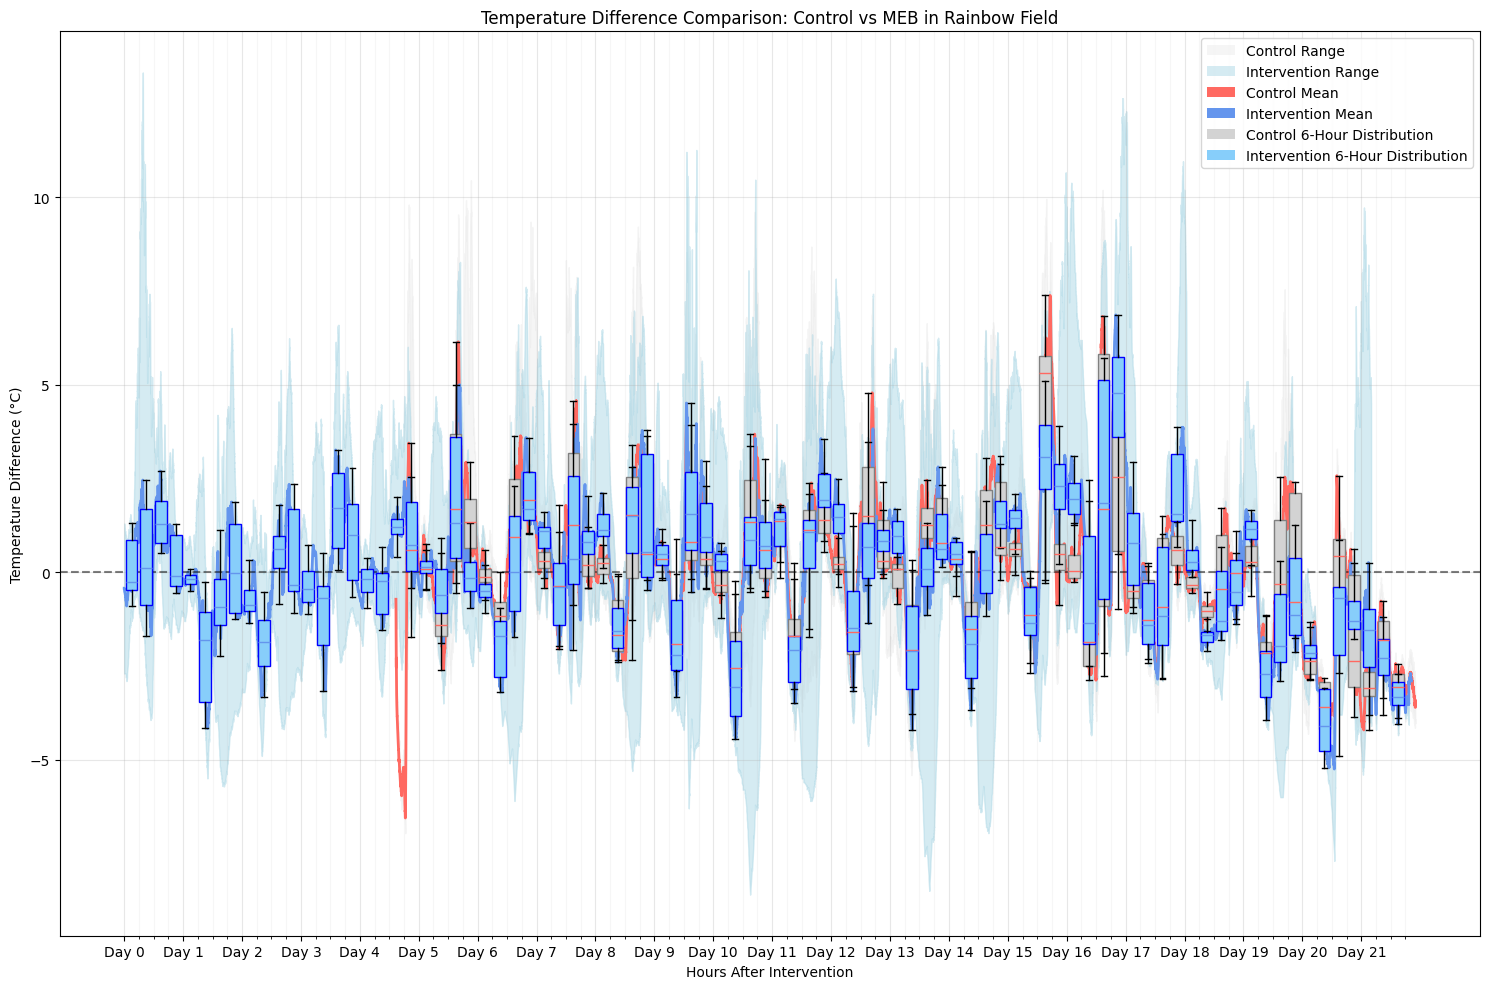

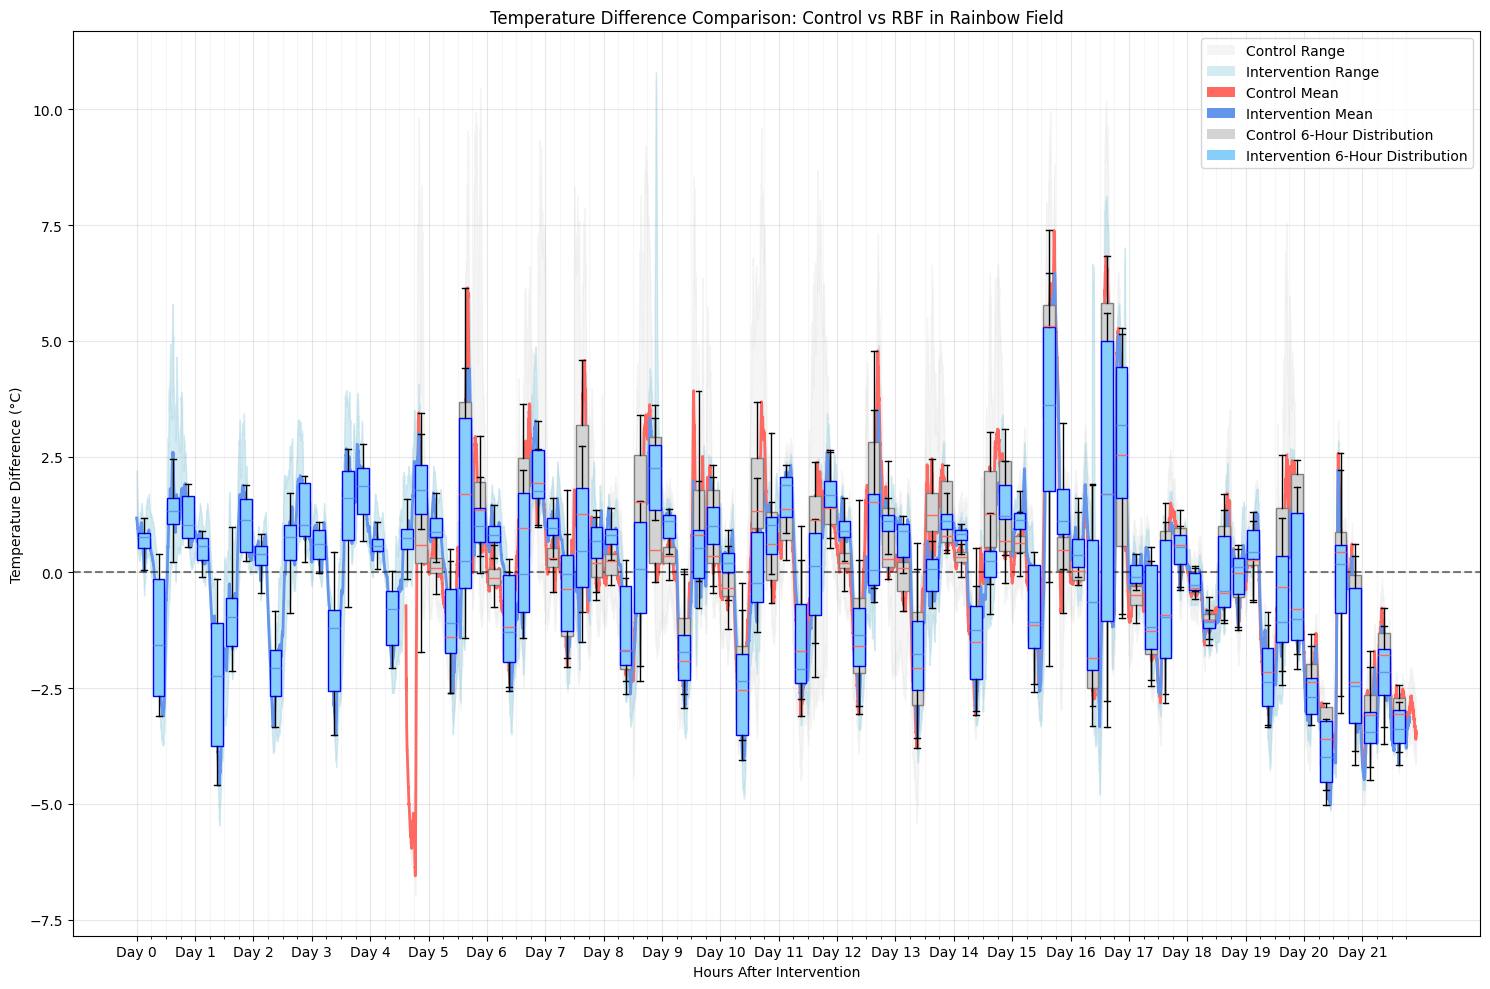

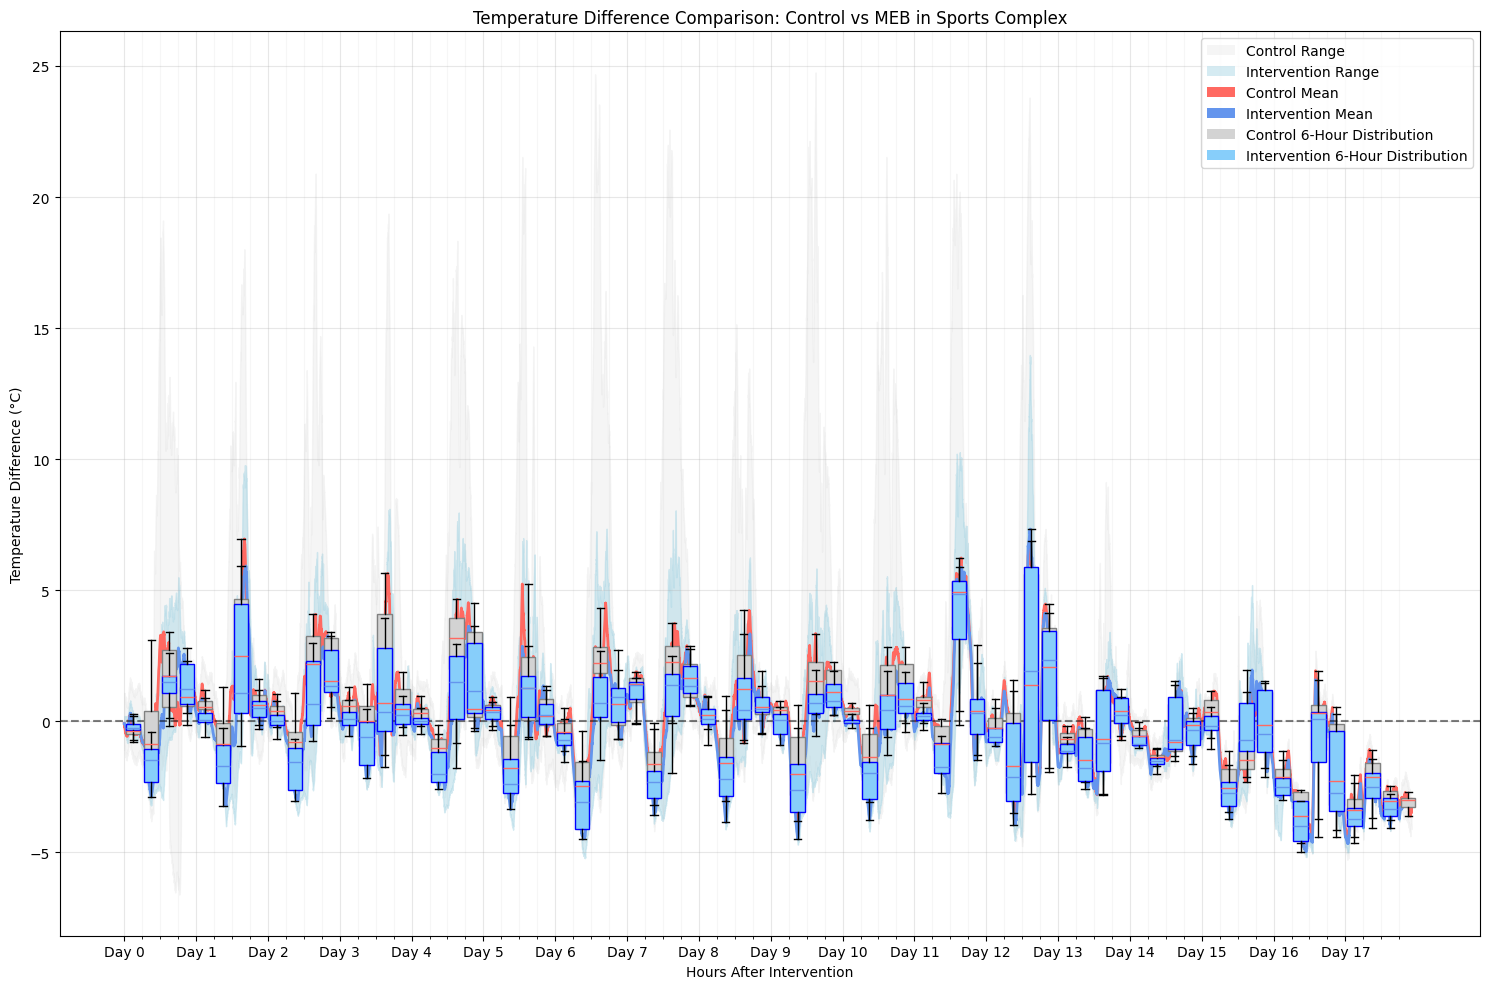

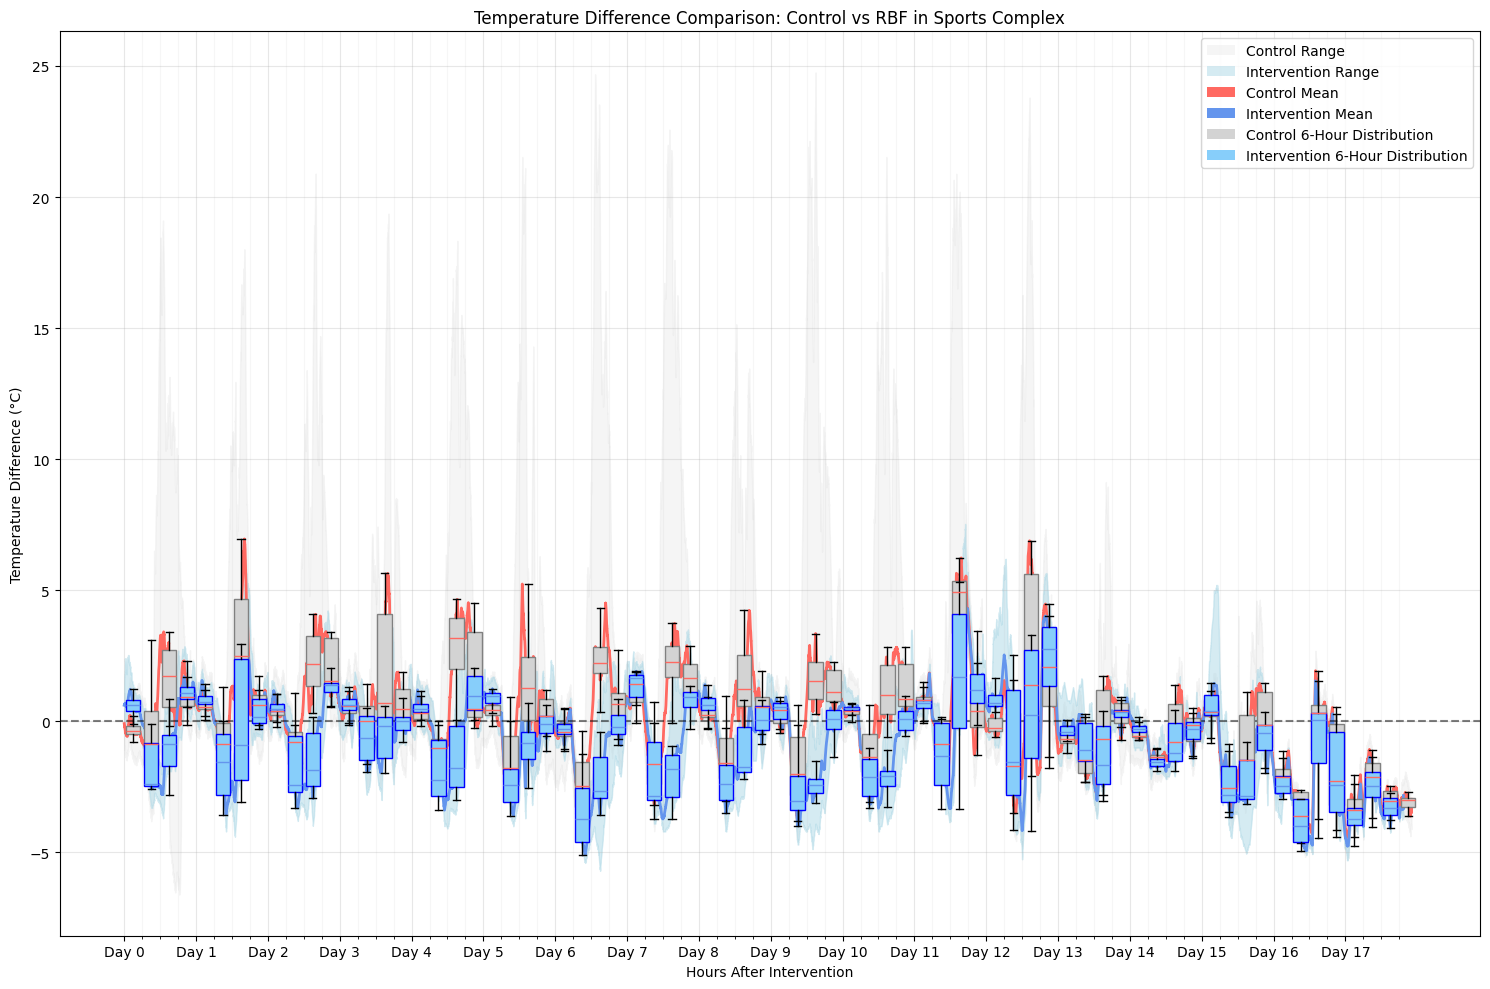

In [1]:
import pandas as pd
import numpy.ma as ma
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

def create_hourly_difference_comparison_plot(
    settlement, 
    intervention_type='MEB', 
    hour_distribution=2,
    colors=None
):
    """
    Create comparison plot of temperature differences with configurable hour distribution and colors
    
    Parameters:
    -----------
    settlement : str
        Name of the settlement
    intervention_type : str
        Type of intervention (default: 'MEB')
    hour_distribution : int
        Number of hours to group for each box plot
    colors : dict, optional
        Dictionary to customize plot colors
    """
    default_colors = {
        'control_range': 'lightgray',
        'intervention_range': 'lightblue',
        'control_mean': 'red',
        'intervention_mean': 'blue',
        'control_box': 'lightgray',
        'intervention_box': 'lightblue'
    }
    
    if colors is not None:
        default_colors.update(colors)
    
    # Load temperature differences instead of master dataframe
    temp_diff_df = pd.read_csv('temperature_differences.csv', parse_dates=['DateTime'])
    logger_flags_df = pd.read_csv('logger_flags.csv')

    # Get loggers for control and intervention groups
    control_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) & 
        (logger_flags_df['Intervention'] == 'CONTROL')
    ]['Loggers'].tolist()
    
    intervention_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) & 
        (logger_flags_df['Intervention'] == intervention_type)
    ]['Loggers'].tolist()

    # Get intervention start date
    intervention_start = pd.to_datetime(
        logger_flags_df[
            (logger_flags_df['Settlement'] == settlement) & 
            (logger_flags_df['Intervention'] == intervention_type)
        ]['Intervention_Start'].iloc[0]
    )

    temp_diff_df['DateTime'] = pd.to_datetime(temp_diff_df['DateTime'])
    post_intervention_df = temp_diff_df[temp_diff_df['DateTime'] >= intervention_start].copy()
    post_intervention_df['Hours_After_Intervention'] = (
        post_intervention_df['DateTime'] - intervention_start
    ).dt.total_seconds() / 3600

    def calculate_hourly_diff_stats(loggers, df):
        hourly_stats = pd.DataFrame()
        logger_data = df[loggers]
        hourly_stats['max'] = logger_data.max(axis=1)
        hourly_stats['min'] = logger_data.min(axis=1)
        hourly_stats['mean'] = logger_data.mean(axis=1)
        hourly_stats['std'] = logger_data.std(axis=1)
        hourly_stats['Hours_After_Intervention'] = df['Hours_After_Intervention']
        return hourly_stats

    control_stats = calculate_hourly_diff_stats(control_loggers, post_intervention_df)
    intervention_stats = calculate_hourly_diff_stats(intervention_loggers, post_intervention_df)

    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot ranges
    control_range = ax.fill_between(control_stats['Hours_After_Intervention'],
                                  control_stats['max'],
                                  control_stats['min'],
                                  alpha=0.3,
                                  color=default_colors['control_range'],
                                  label='Control Range')

    intervention_range = ax.fill_between(intervention_stats['Hours_After_Intervention'],
                                       intervention_stats['max'],
                                       intervention_stats['min'],
                                       alpha=0.5,
                                       color=default_colors['intervention_range'],
                                       label='Intervention Range')

    # Plot mean lines
    control_mean, = ax.plot(control_stats['Hours_After_Intervention'],
                          control_stats['mean'],
                          color=default_colors['control_mean'],
                          label='Control Mean',
                          linewidth=2)
    
    intervention_mean, = ax.plot(intervention_stats['Hours_After_Intervention'],
                               intervention_stats['mean'],
                               color=default_colors['intervention_mean'],
                               label='Intervention Mean',
                               linewidth=2)

    # Add reference line at y=0
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    control_boxes = []
    intervention_boxes = []

    box_width = hour_distribution * 0.8
    max_hours = max(control_stats['Hours_After_Intervention'])
    
    # Create box plots
    for hour in np.arange(0, max_hours, hour_distribution):
        control_period = control_stats[
            (control_stats['Hours_After_Intervention'] >= hour) & 
            (control_stats['Hours_After_Intervention'] < hour + hour_distribution)
        ]
        intervention_period = intervention_stats[
            (intervention_stats['Hours_After_Intervention'] >= hour) & 
            (intervention_stats['Hours_After_Intervention'] < hour + hour_distribution)
        ]

        if len(control_period) > 0:
            control_box = ax.boxplot(control_period['mean'],
                                   positions=[hour + hour_distribution/2],
                                   widths=box_width,
                                   patch_artist=True,
                                   boxprops=dict(facecolor=default_colors['control_box'], color='gray'),
                                   medianprops=dict(color=default_colors['control_mean']),
                                   showfliers=False)
            control_boxes.append(control_box)
            
        if len(intervention_period) > 0:
            intervention_box = ax.boxplot(intervention_period['mean'],
                                        positions=[hour + hour_distribution/2],
                                        widths=box_width,
                                        patch_artist=True,
                                        boxprops=dict(facecolor=default_colors['intervention_box'], color='blue'),
                                        medianprops=dict(color=default_colors['intervention_mean']),
                                        showfliers=False)
            intervention_boxes.append(intervention_box)

    # Create legend
    distribution_label = f'{hour_distribution}-Hour Distribution'
    legend_elements = [
        (Patch(facecolor=default_colors['control_range'], alpha=0.3), [control_range], 'Control Range'),
        (Patch(facecolor=default_colors['intervention_range'], alpha=0.5), [intervention_range], 'Intervention Range'),
        (Patch(facecolor=default_colors['control_mean']), [control_mean], 'Control Mean'),
        (Patch(facecolor=default_colors['intervention_mean']), [intervention_mean], 'Intervention Mean'),
        (Patch(facecolor=default_colors['control_box'], alpha=1.0), 
         control_boxes, 
         f'Control {distribution_label}'),
        (Patch(facecolor=default_colors['intervention_box'], alpha=1.0), 
         intervention_boxes, 
         f'Intervention {distribution_label}')
    ]

    leg = ax.legend([item[0] for item in legend_elements],
                   [item[2] for item in legend_elements],
                   loc='upper right')

    # Make legend interactive
    lined = {}
    for legpatch, elements, label in legend_elements:
        legline = leg.get_patches()[legend_elements.index((legpatch, elements, label))]
        if distribution_label in label:
            lined[legline] = elements
        else:
            lined[legline] = elements

    def on_pick(event):
        legline = event.artist
        if legline in lined:
            elements = lined[legline]
            
            if isinstance(elements[0], dict): 
                visible = not any(box['boxes'][0].get_visible() for box in elements)
                for box in elements:
                    for component in box.values():
                        for artist in component:
                            artist.set_visible(visible)
            else:
                visible = not elements[0].get_visible()
                for element in elements:
                    element.set_visible(visible)
            
            legline.set_alpha(1.0 if visible else 0.2)
            fig.canvas.draw()

    for legline in leg.get_patches():
        legline.set_picker(True)

    fig.canvas.mpl_connect('pick_event', on_pick)

    # Set labels and title
    ax.set_xlabel('Hours After Intervention')
    ax.set_ylabel('Temperature Difference (°C)')
    ax.set_title(f'Temperature Difference Comparison: Control vs {intervention_type} in {settlement}')

    # Set x-axis ticks
    xticks = np.arange(0, max_hours, 24)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f'Day {int(x/24)}' for x in xticks])
    
    minor_xticks = np.arange(0, max_hours, hour_distribution)
    ax.set_xticks(minor_xticks, minor=True)

    # Add grid
    ax.grid(True, alpha=0.3)
    ax.grid(True, which='minor', alpha=0.1)
    plt.tight_layout()
    plt.show()

# Settings for the plots
settlements = ['Rainbow Field', 'Sports Complex']
intervention_types = ['MEB', 'RBF']
hour_distribution = 6  # Change this value to adjust hour distribution

custom_colors = {
    'control_range': '#E0E0E0',  # Light gray
    'intervention_range': '#ADD8E6',  # Light blue
    'control_mean': '#FF6961',  # Soft red
    'intervention_mean': '#6495ED',  # Cornflower blue
    'control_box': '#D3D3D3',  # Light gray
    'intervention_box': '#87CEFA'  # Light sky blue
}

# Generate plots
for settlement in settlements:
    for intervention_type in intervention_types:
        create_hourly_difference_comparison_plot(
            settlement, 
            intervention_type, 
            hour_distribution,
            colors=custom_colors
        )

## Average Day Comparison for Control and Intervention Groups for an average "Full Day", "Day" and "Night" via Temperature Differences

This script focuses on comparing the **average daily temperature differences** between control and intervention groups across different periods: **Full Day**, **Day**, and **Night**. It creates comparison plot of temperature differences for an average 24-hour day. The temperature differences are calculated by subtracting the minimum temperature at night from the maximum temperature during the day. The plot shows the temperature differences for an average day in the summer

- **Plot Scope - Average 24-Hour Period:**
  - Visualizes temperature differences for an **average day**, with distinctions between **Full Day**, **Daytime (6 AM–6 PM)**, and **Nighttime (7 PM–5 AM)** periods.

- **Temperature Calculation Methodology**  
  - The **means**, **maximums**, and **minimums** are **not aggregated across the entire time period directly**.  
  - Instead:
    - For each **hour** of the day, the mean, max, and min values are calculated **for each day**.
    - These **hourly values** are then **averaged across all days** to obtain the final metrics for plotting.  
  - It ensured that variations are preserved on an **hourly scale** and provides a consistent basis for comparison across control and intervention groups.

- **Period-Specific Data Segmentation:**
  - **Daytime:** Filters data for hours between 6 AM and 6 PM.
  - **Nighttime:** Combines evening hours (7 PM–11 PM) and early morning hours (12 AM–5 AM), and adjusts plot x-axis for continuous visualization across two calendar days.
  - **Full Day:** Uses the entire 24-hour data.

- **Statistical Processing for Hourly Aggregates:**
  - Calculates mean, max, min, and standard deviation for each hour within the specified period. 
  - Adjusts hour labels for Nighttime plots to maintain chronological order.

- **Distinct Visualization Features:**
  - For **Nighttime**, the x-axis covers **19–29**, where hours beyond 24 represent early morning (0–5) for continuity.
  - Adds hourly box plots for both control and intervention groups, with distinct colors for each intervention type.
  - Incorporates an **interactive legend** to toggle the visibility of ranges and box plots.



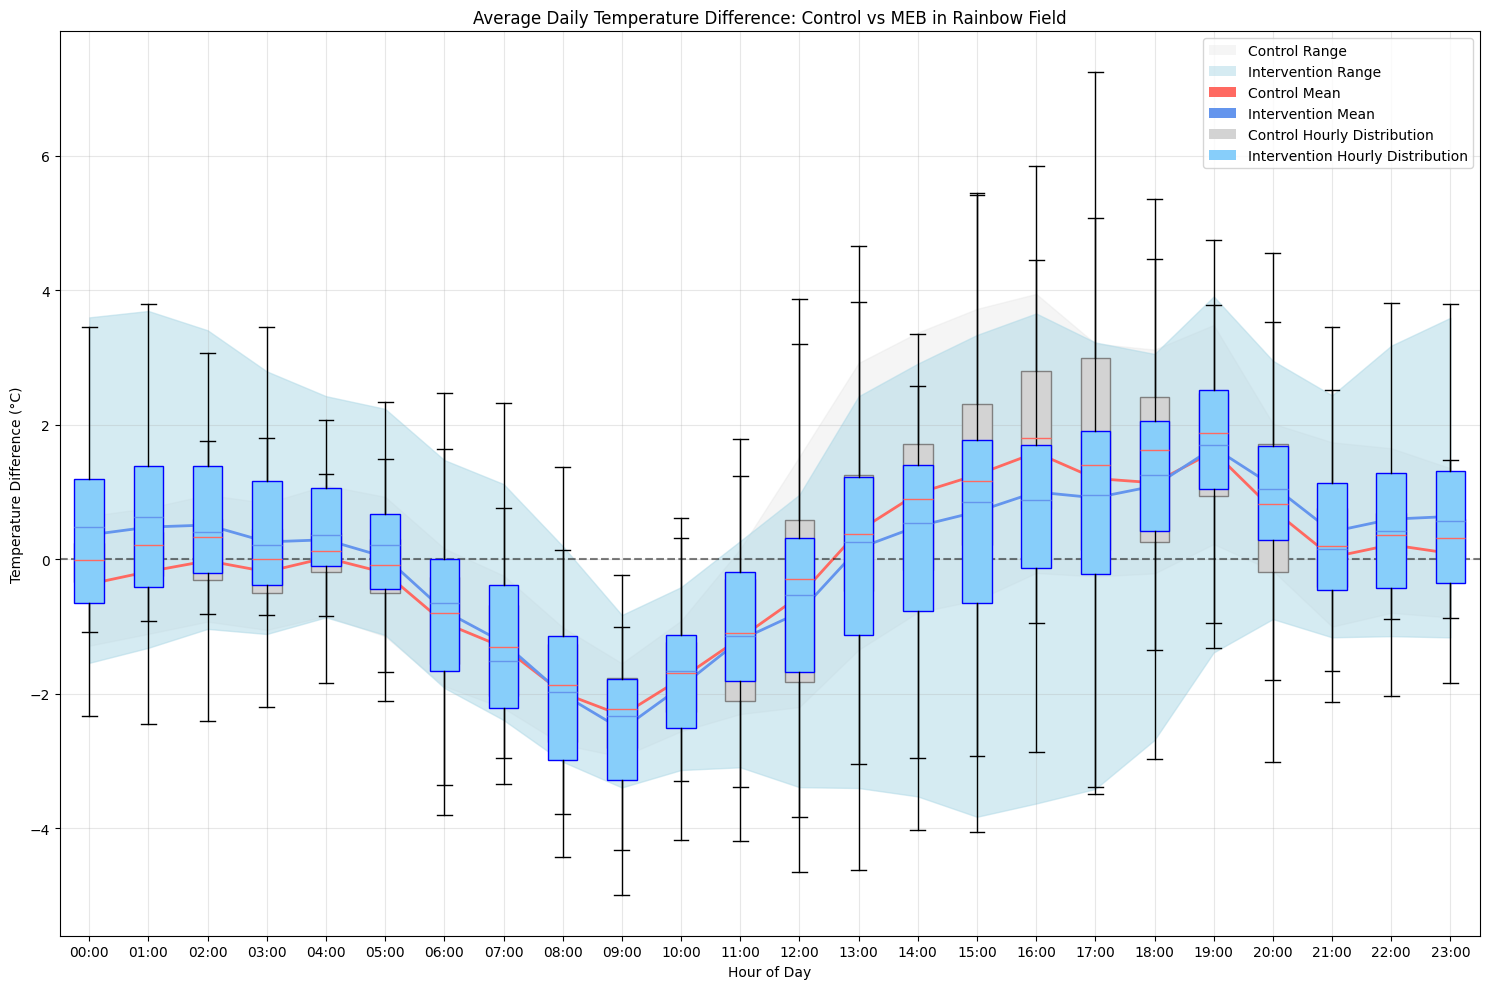

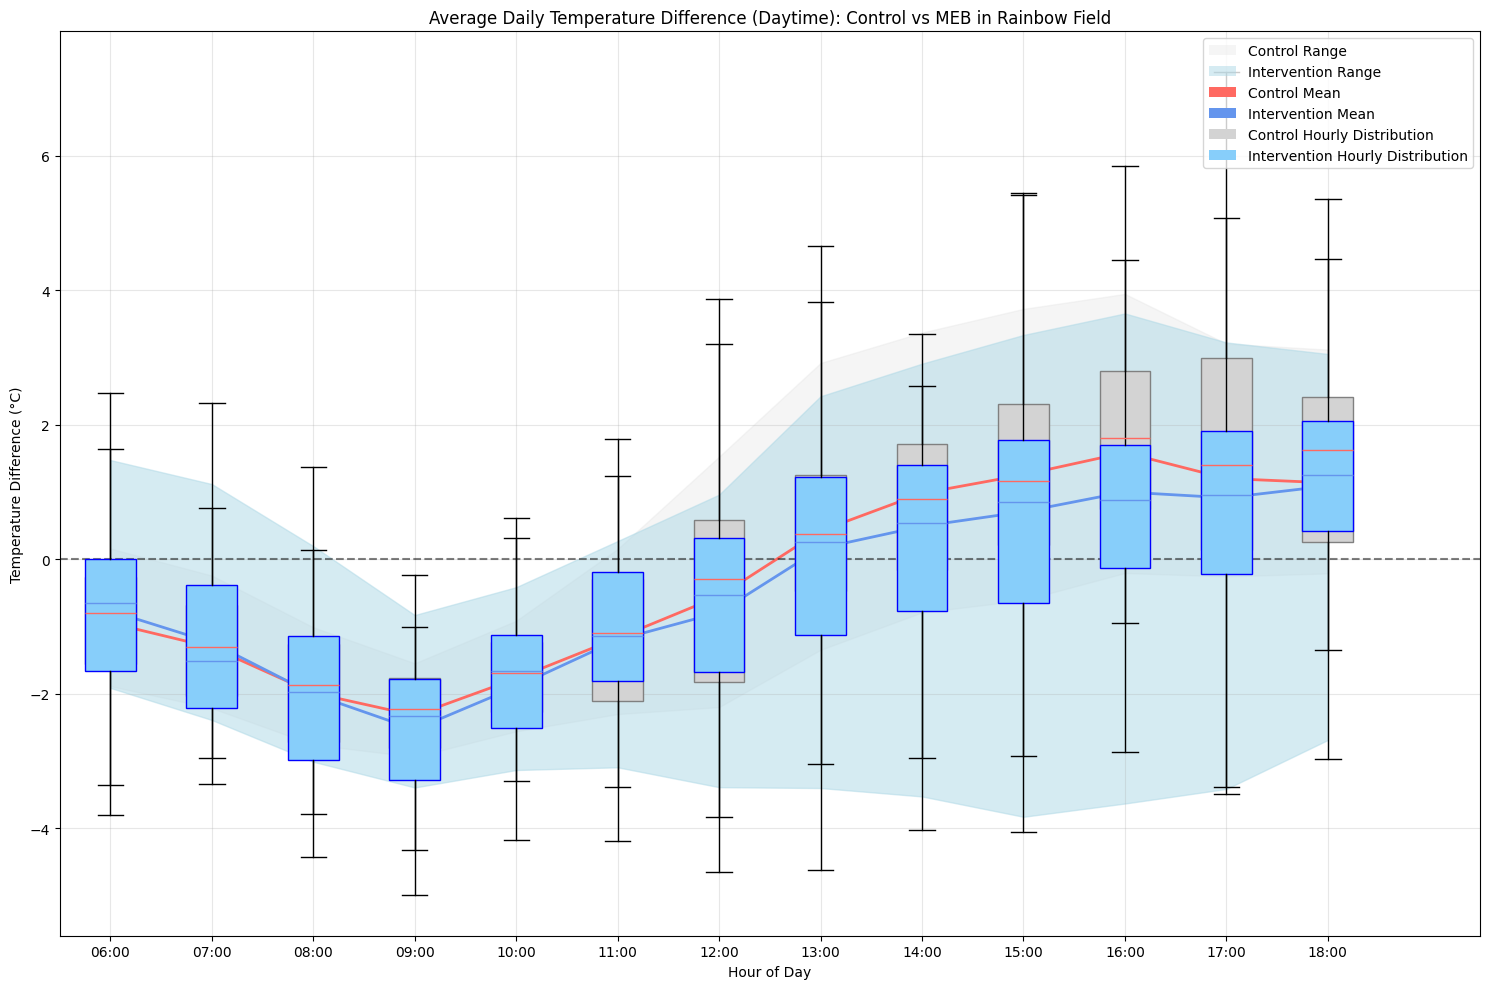

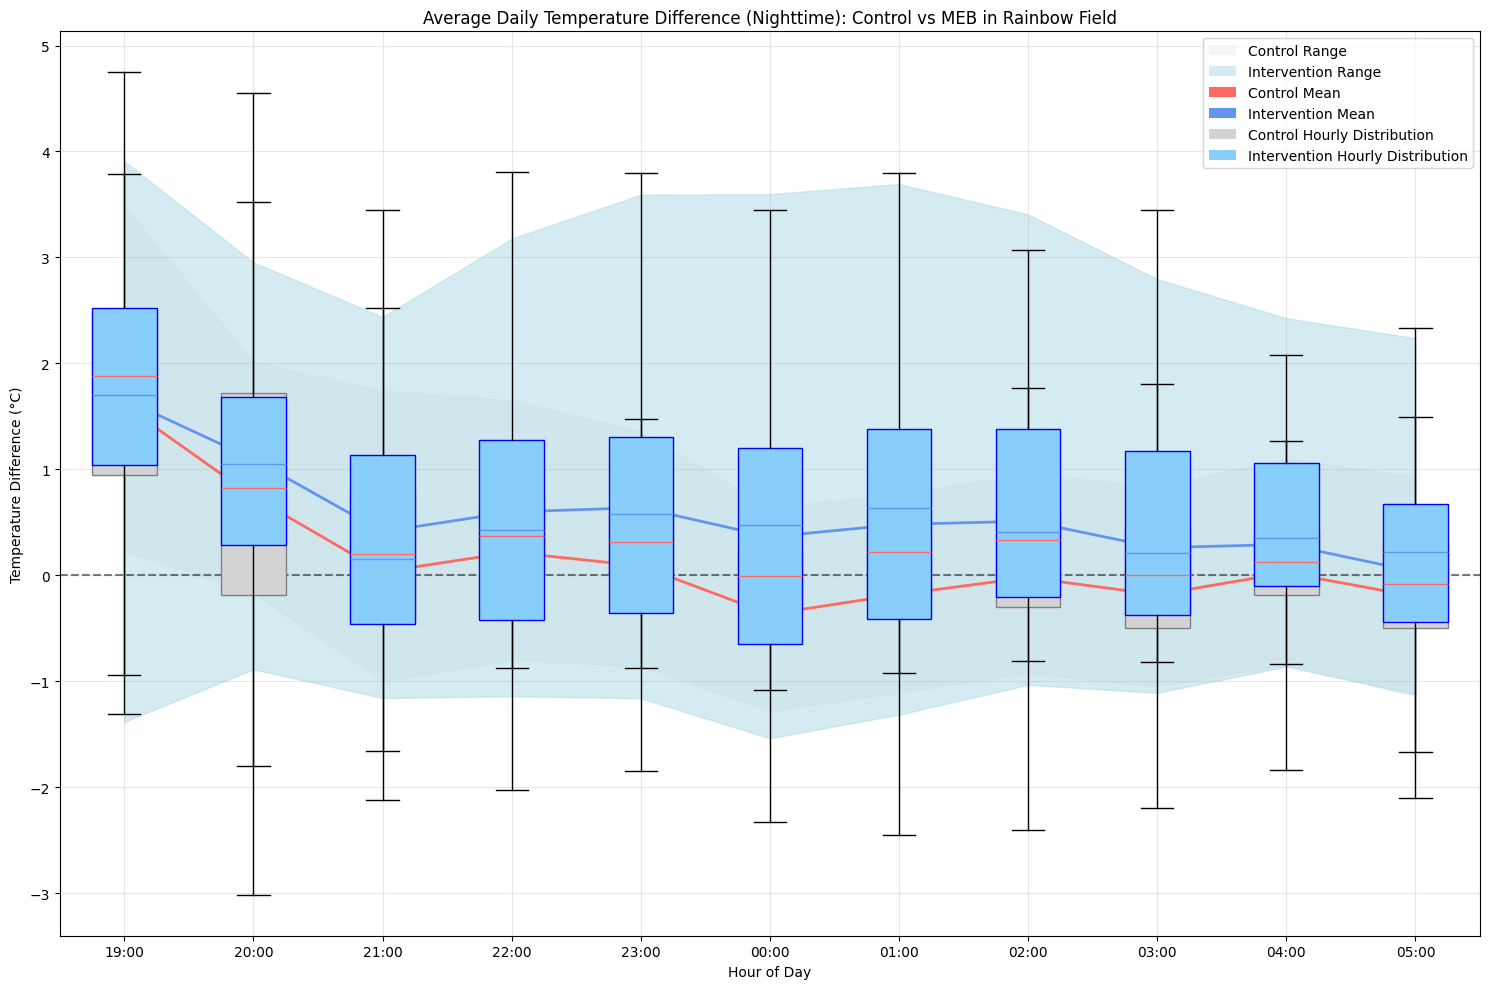

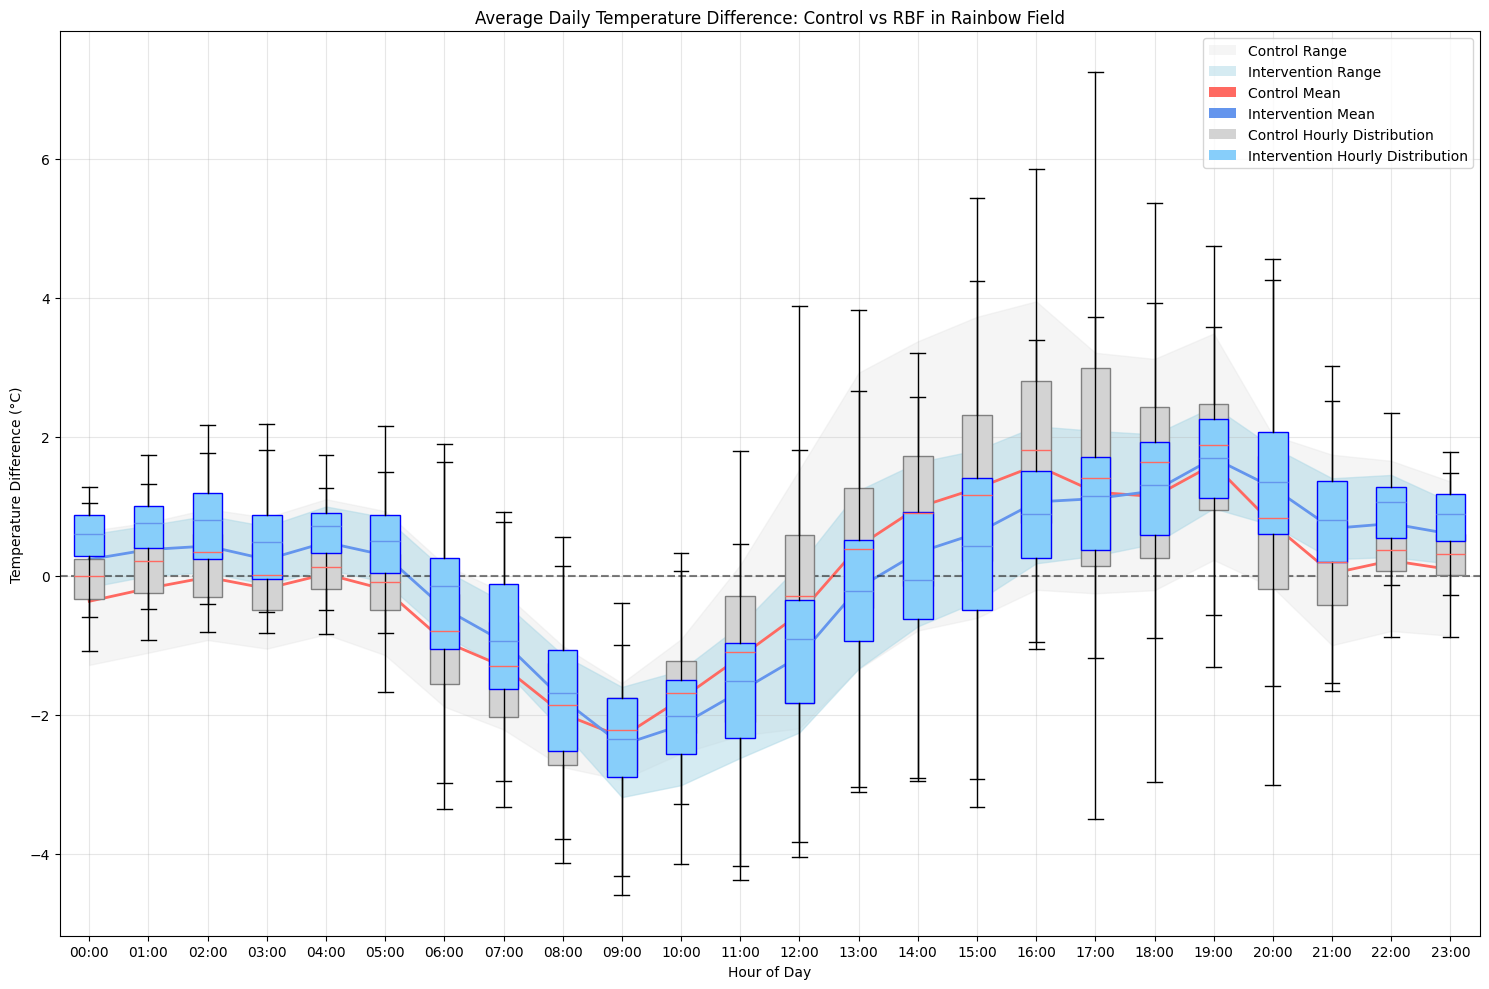

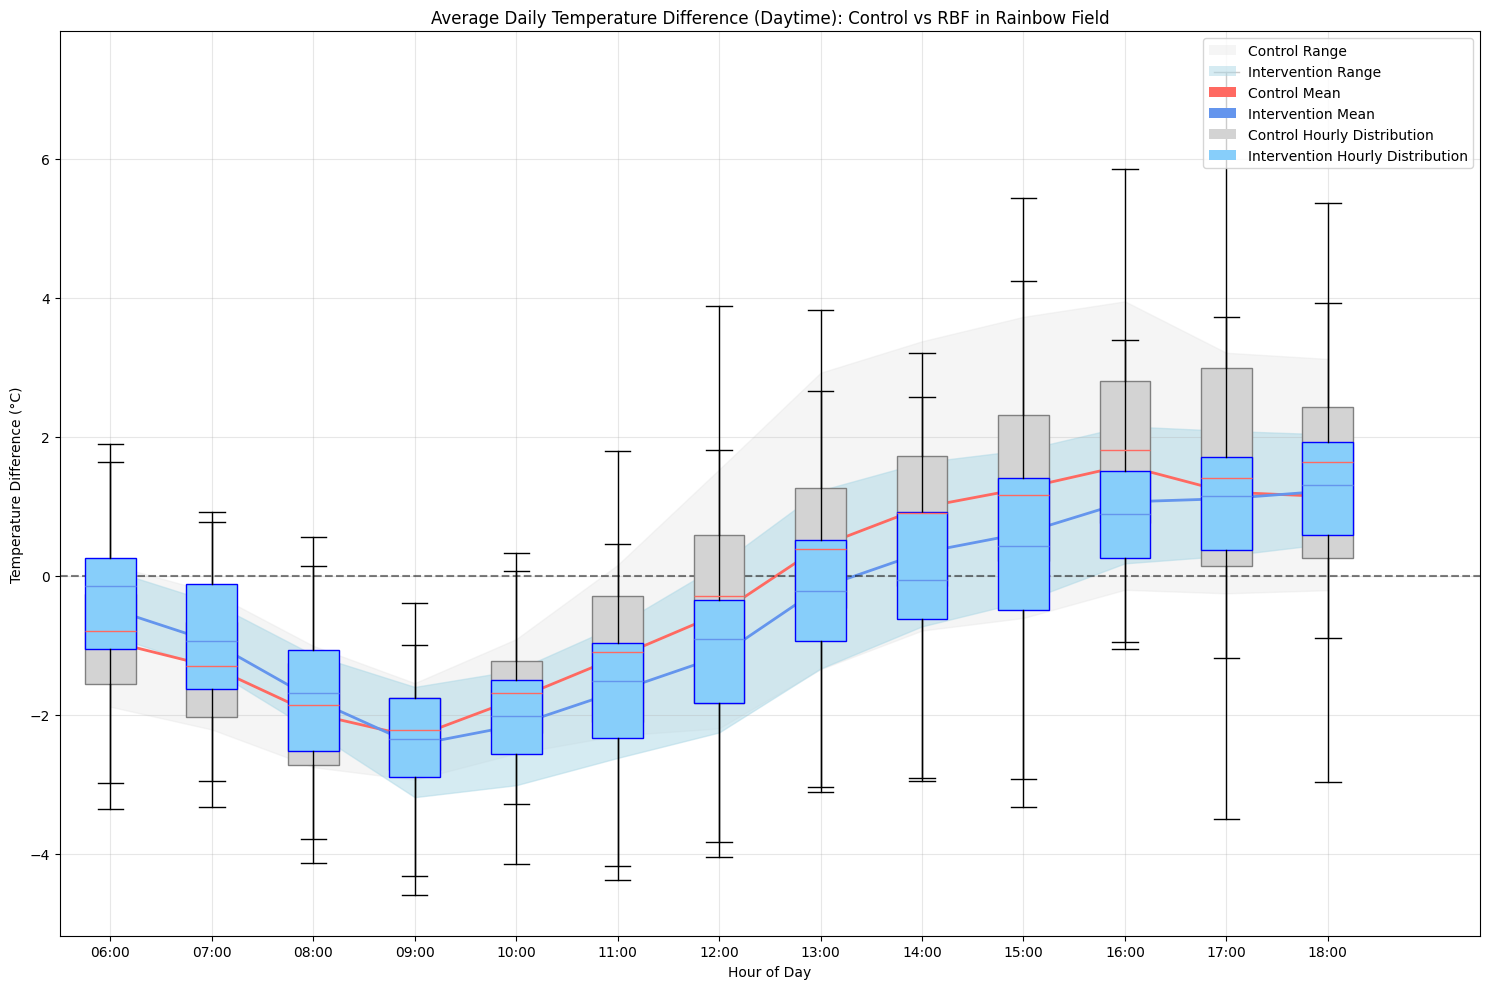

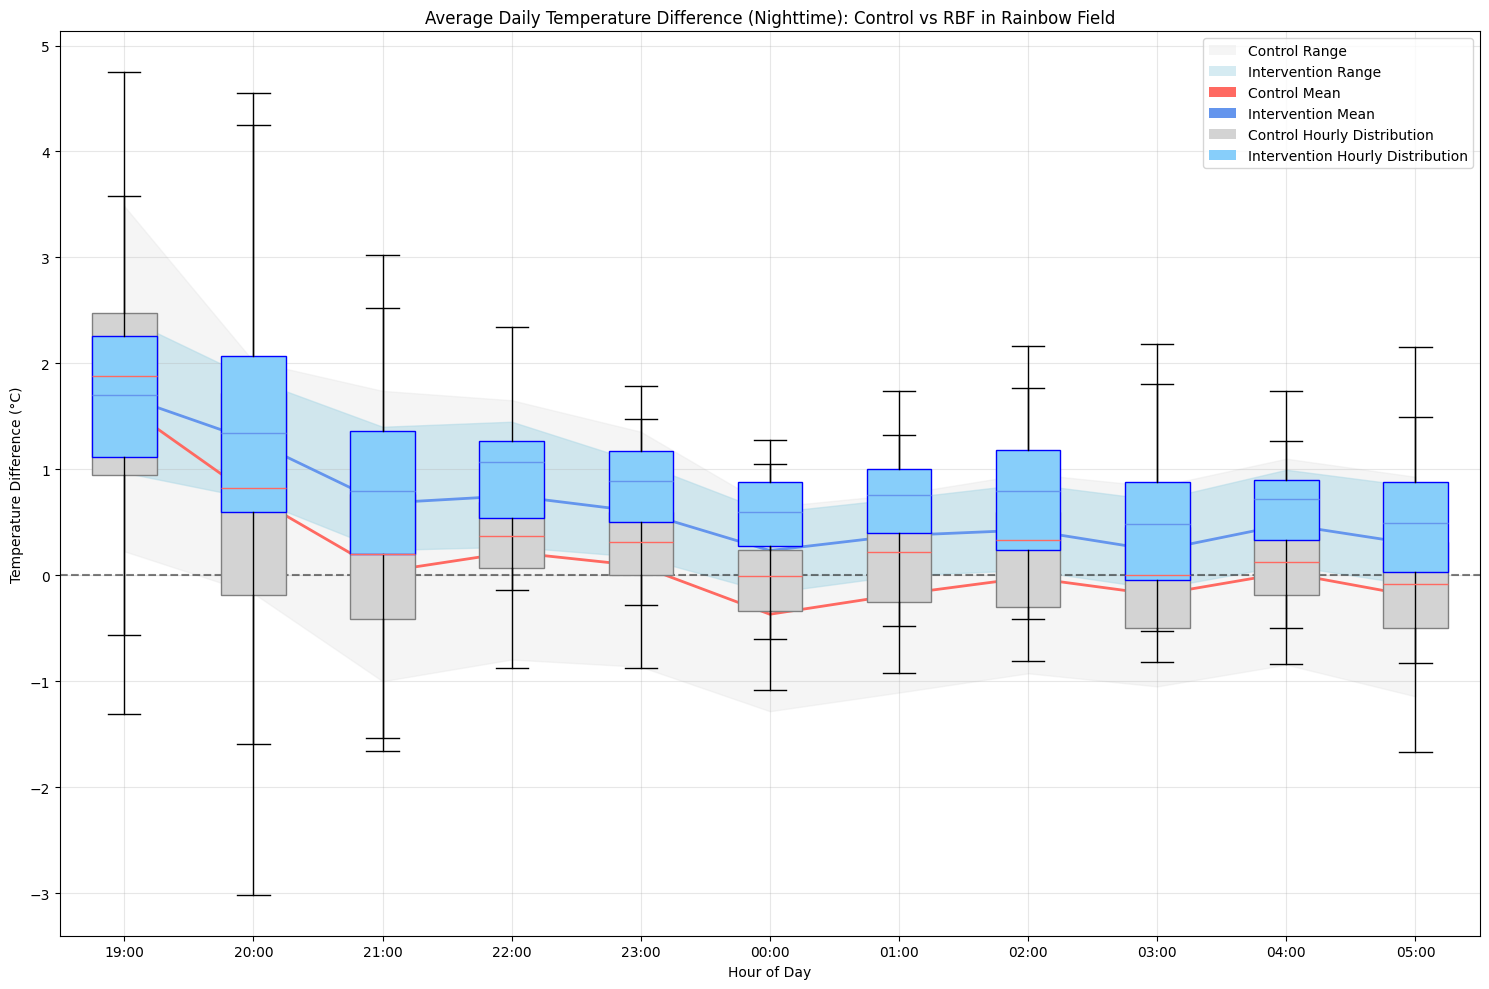

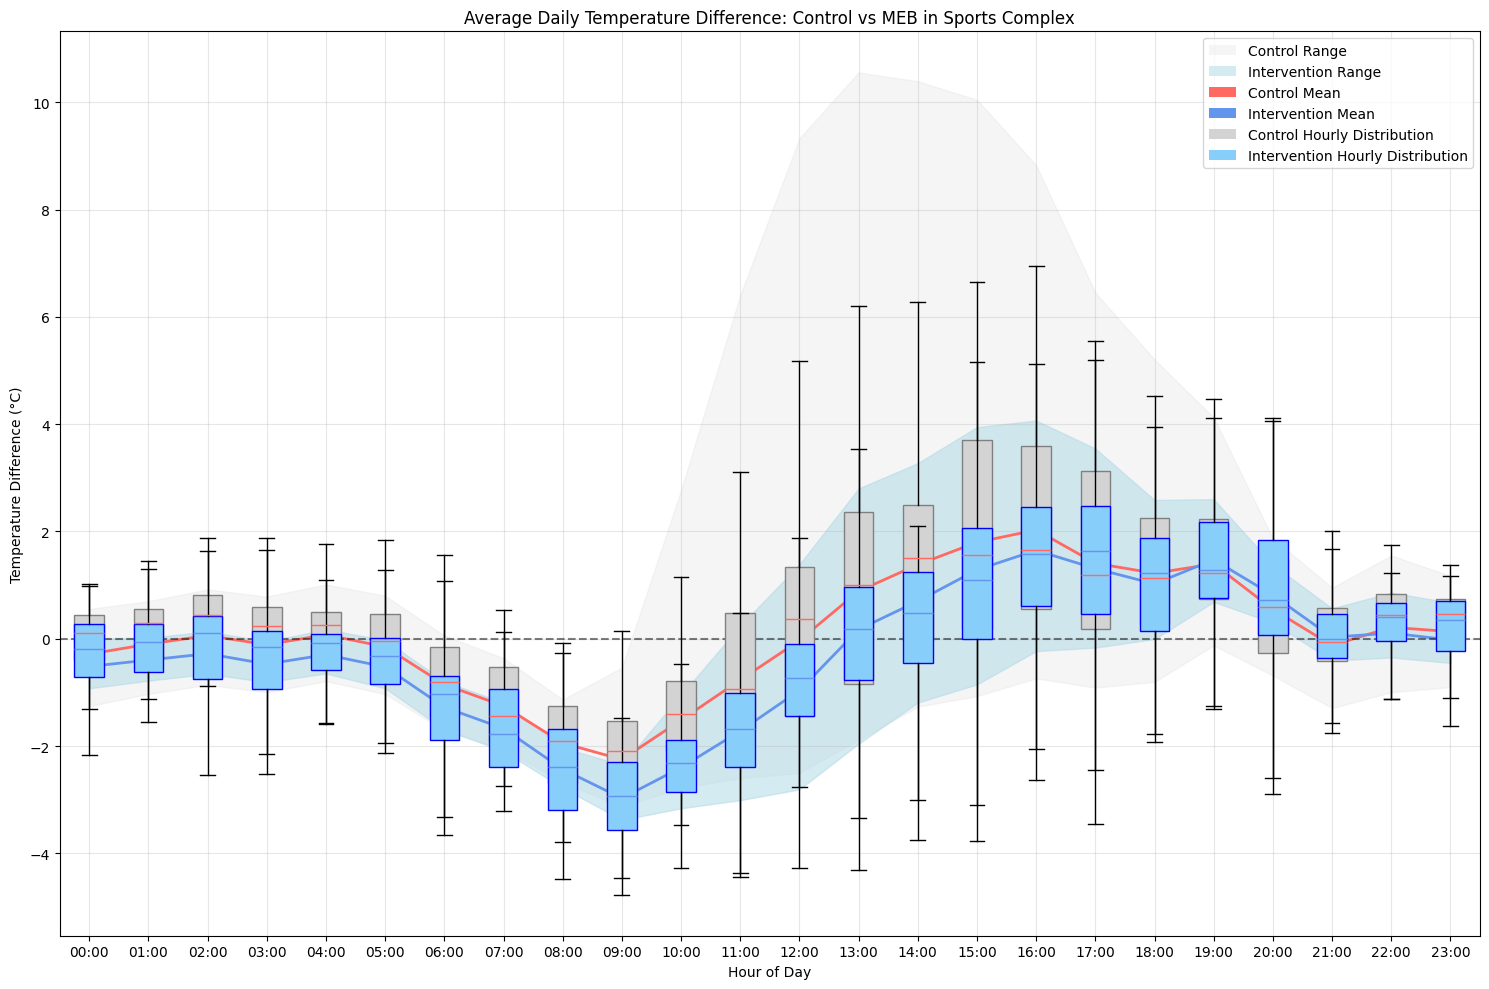

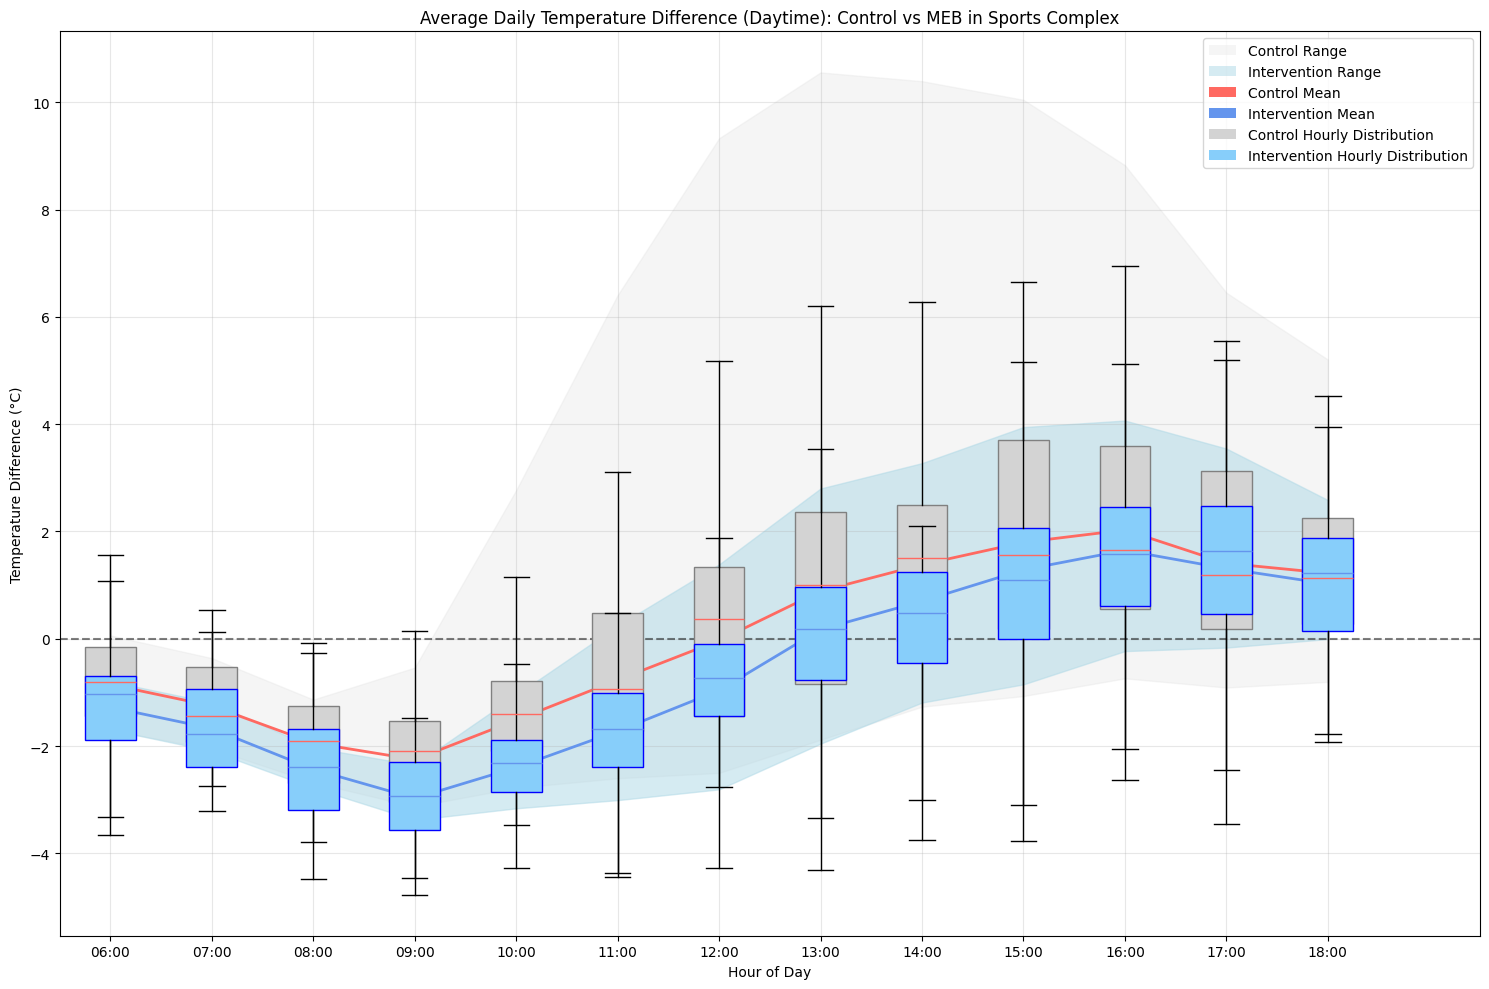

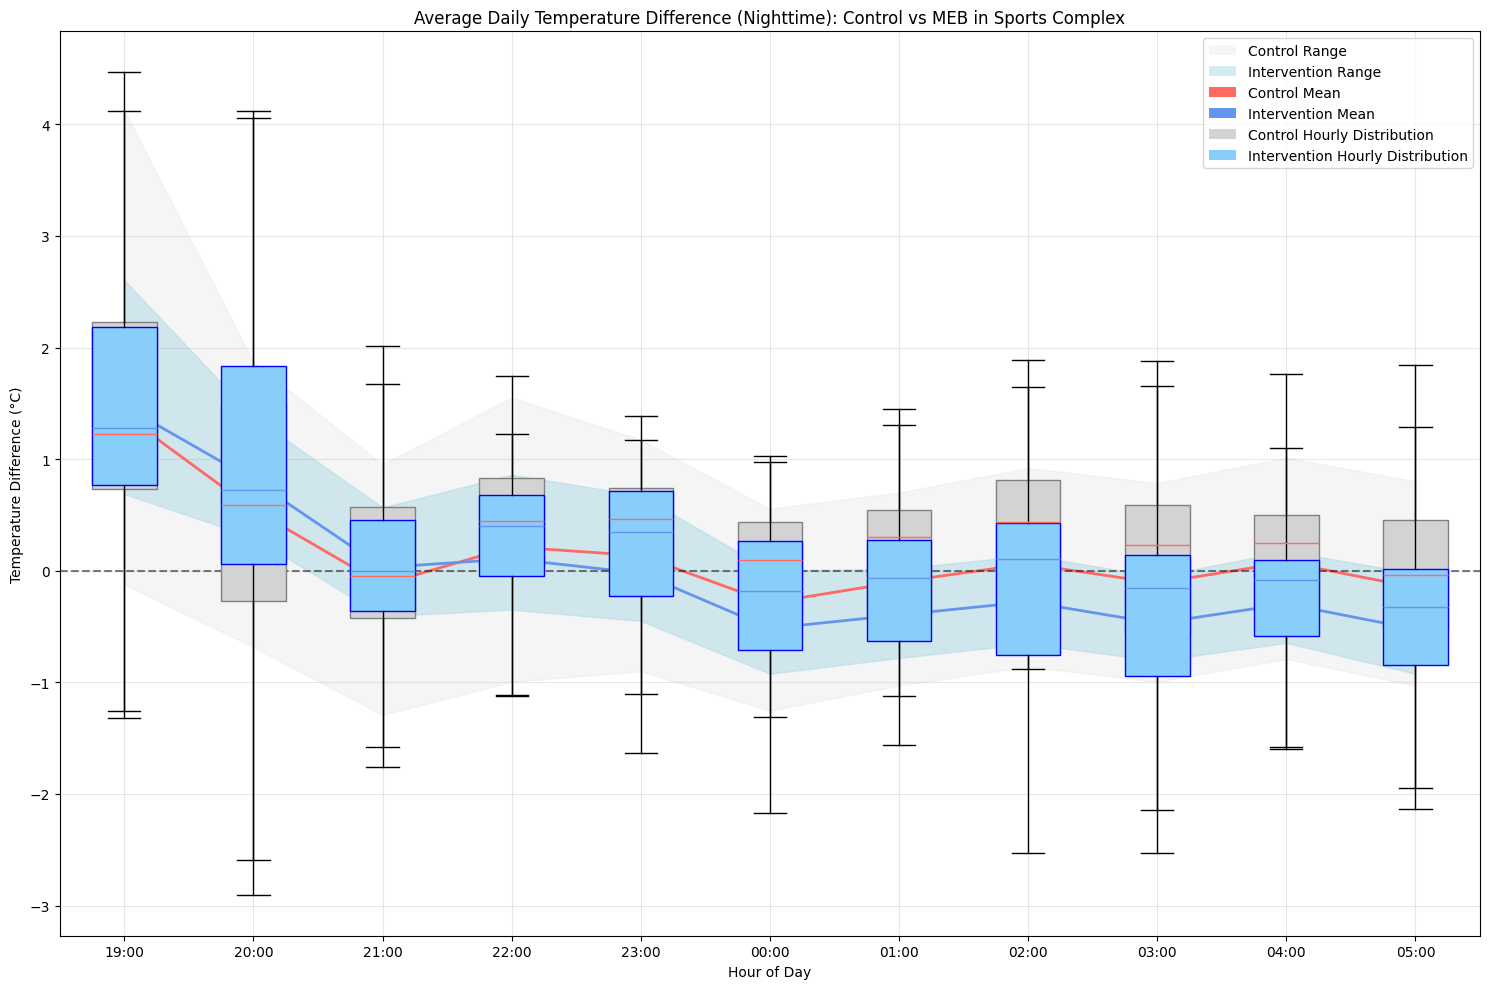

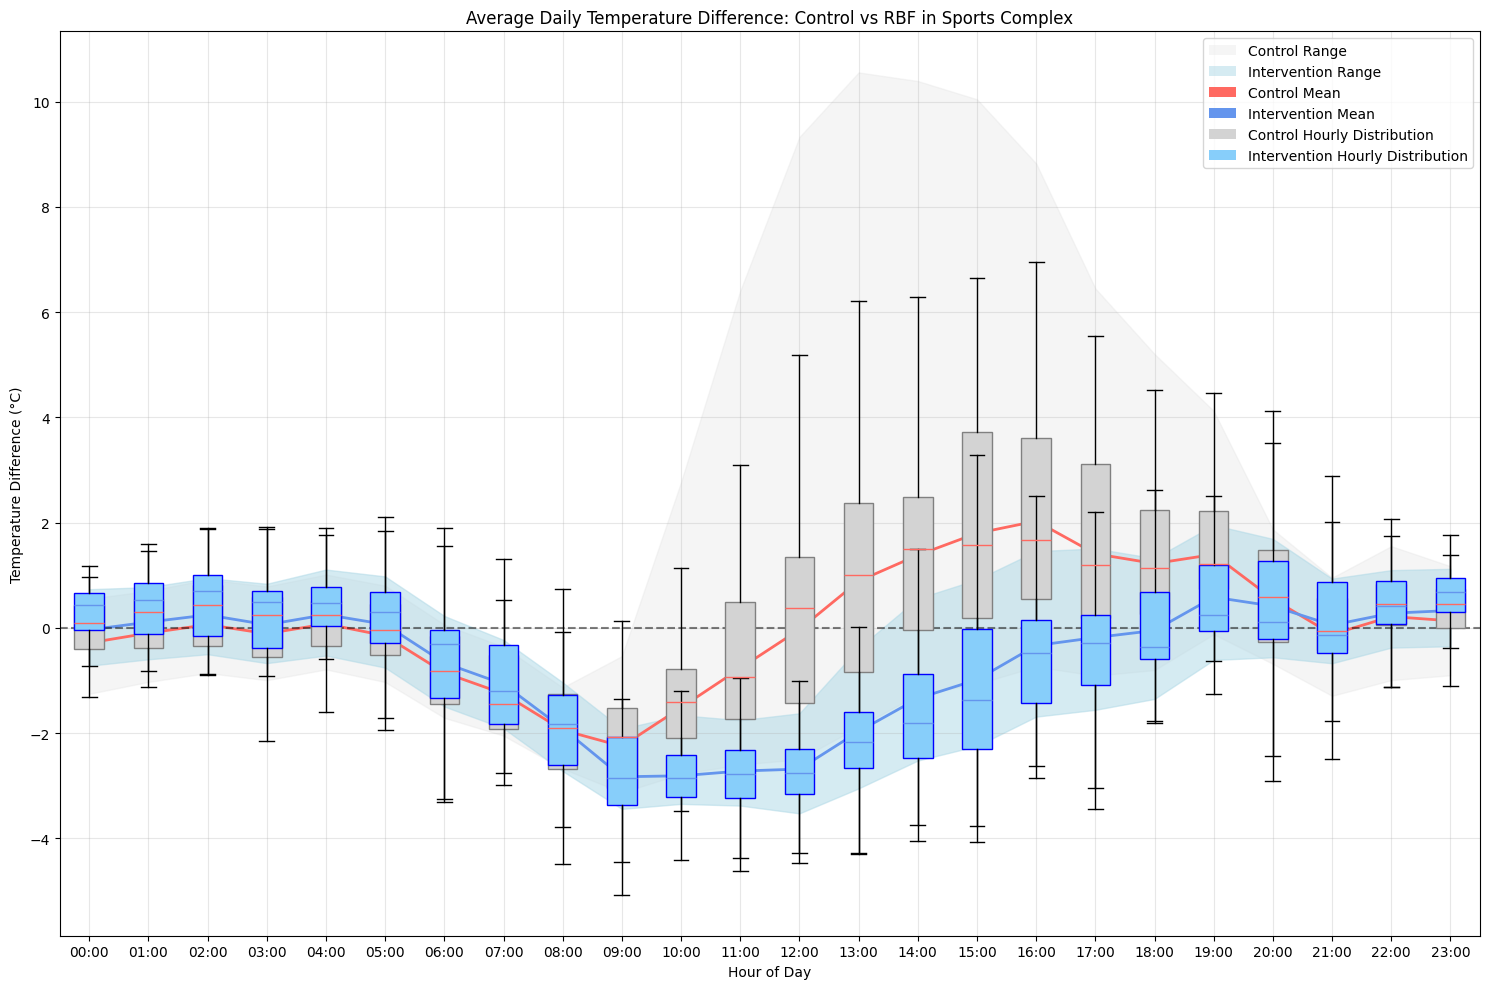

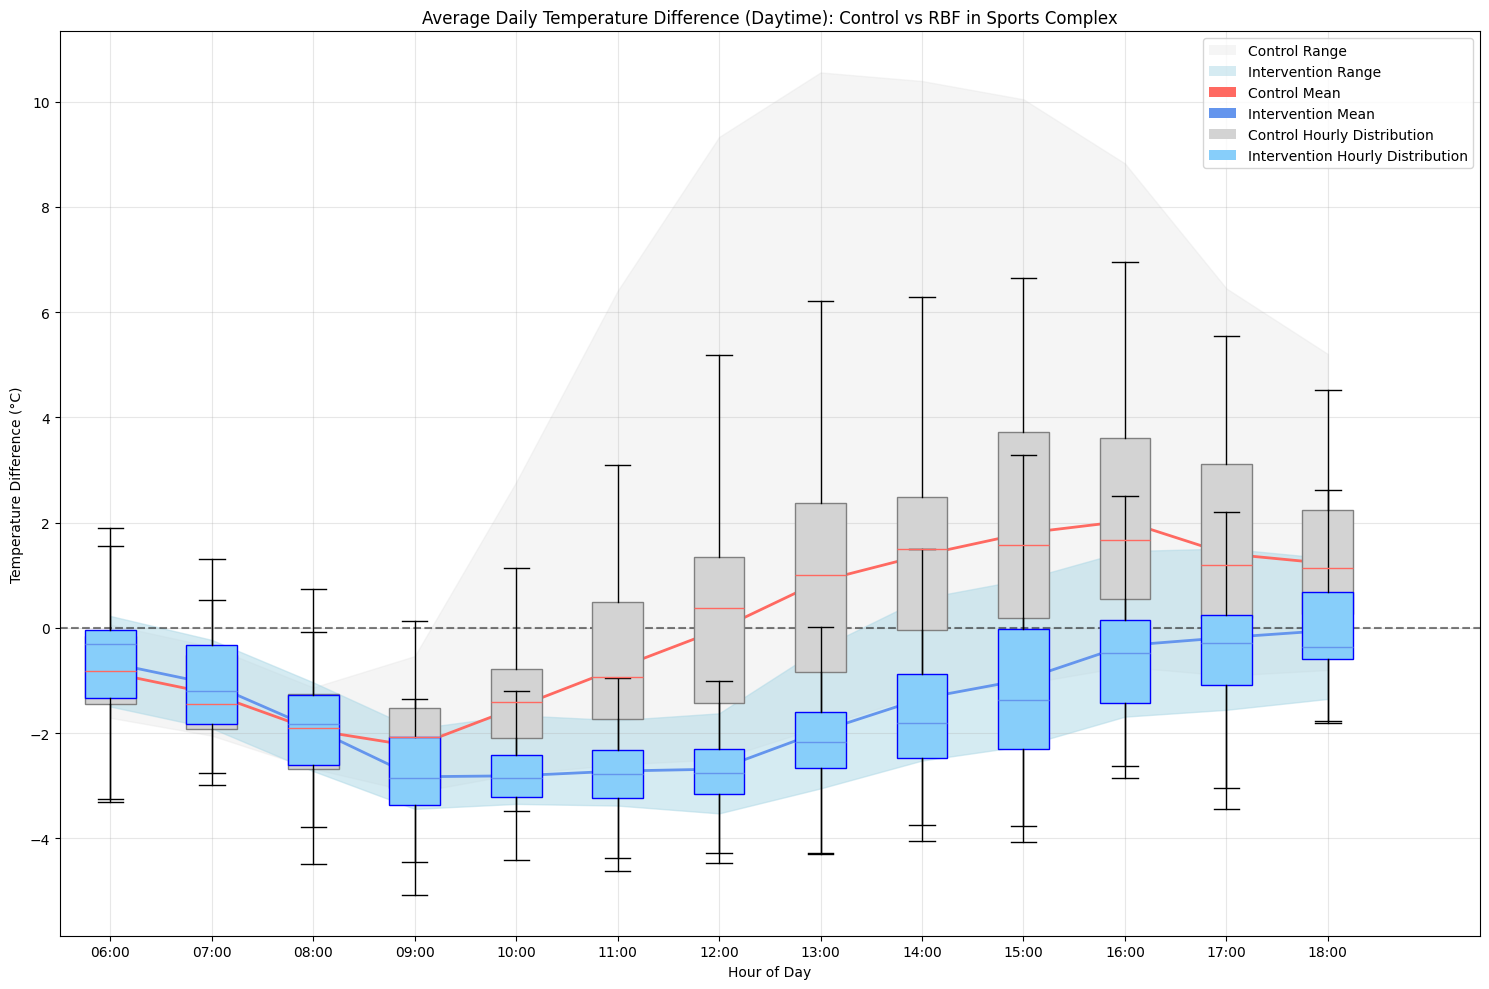

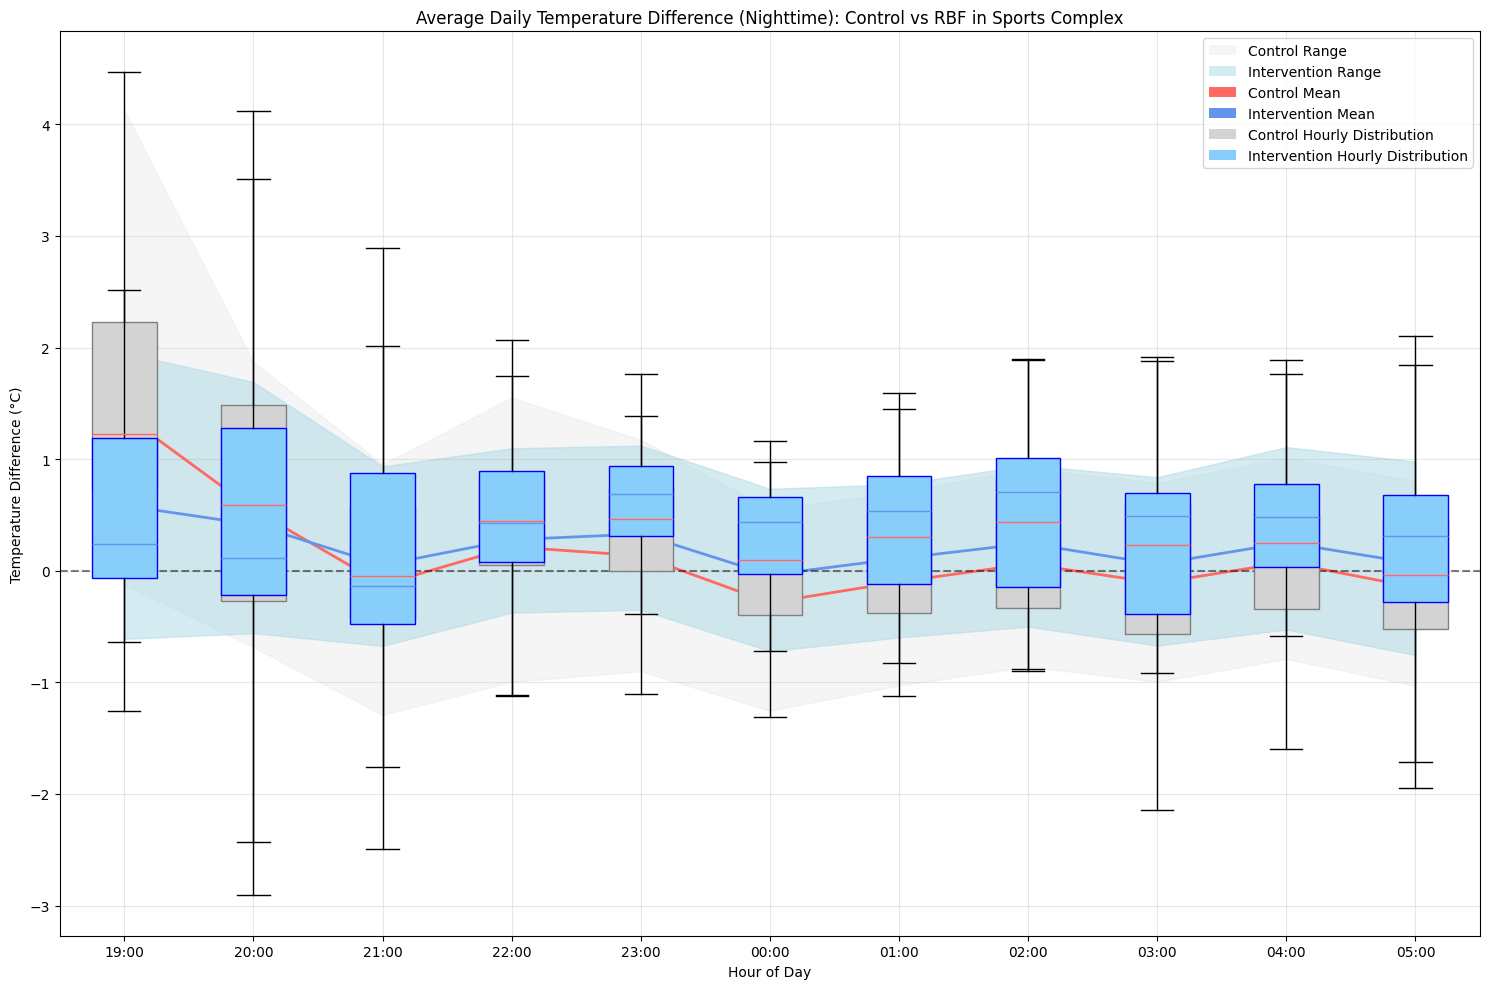

In [2]:
import pandas as pd
import numpy.ma as ma
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

def create_average_day_comparison_plot(
    settlement, 
    intervention_type='MEB',
    period='Full',  # 'Full', 'Day', or 'Night'
    colors=None
):
    """
    Create comparison plot of temperature differences for an average 24-hour day
    
    Parameters:
    -----------
    settlement : str
        Name of the settlement
    intervention_type : str
        Type of intervention (default: 'MEB')
    period : str
        Time period to plot ('Full', 'Day', or 'Night')
    colors : dict, optional
        Dictionary to customize plot colors
    """
    default_colors = {
        'control_range': '#E0E0E0',
        'intervention_range': '#ADD8E6',
        'control_mean': '#FF6961',
        'intervention_mean': '#6495ED',
        'control_box': '#D3D3D3',
        'intervention_box': '#87CEFA'
    }
    
    if colors is not None:
        default_colors.update(colors)
    
    # Load data
    temp_diff_df = pd.read_csv('temperature_differences.csv', parse_dates=['DateTime'])
    logger_flags_df = pd.read_csv('logger_flags.csv')

    # Get loggers
    control_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) & 
        (logger_flags_df['Intervention'] == 'CONTROL')
    ]['Loggers'].tolist()
    
    intervention_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) & 
        (logger_flags_df['Intervention'] == intervention_type)
    ]['Loggers'].tolist()

    intervention_start = pd.to_datetime(
        logger_flags_df[
            (logger_flags_df['Settlement'] == settlement) & 
            (logger_flags_df['Intervention'] == intervention_type)
        ]['Intervention_Start'].iloc[0]
    )

    # Process data
    temp_diff_df['DateTime'] = pd.to_datetime(temp_diff_df['DateTime'])
    post_intervention_df = temp_diff_df[temp_diff_df['DateTime'] >= intervention_start].copy()
    post_intervention_df['Hour'] = post_intervention_df['DateTime'].dt.hour

    # Define hours range based on period
    if period == 'Day':
        post_intervention_df = post_intervention_df[
            (post_intervention_df['Hour'] >= 6) & 
            (post_intervention_df['Hour'] < 19)
        ]
        hours_range = range(6, 19)
    elif period == 'Night':
        post_intervention_df = post_intervention_df[
            (post_intervention_df['Hour'] < 6) | 
            (post_intervention_df['Hour'] >= 19)
        ]
        evening_hours = list(range(19, 24))
        morning_hours = list(range(0, 6))
        hours_range = evening_hours + morning_hours
    else:  # Full day
        hours_range = range(24)

    def calculate_hourly_stats(loggers, df):
        hourly_stats = []
        
        for hour in hours_range:
            hour_data = df[df['Hour'] == hour][loggers]
            hour_data = hour_data.replace(0, np.nan)
            hour_data = hour_data.dropna(how='all')
            
            if not hour_data.empty:
                stats = {
                    'Hour': hour,
                    'plot_hour': hour if period != 'Night' else (hour if hour >= 19 else hour + 24),
                    'max': hour_data.max(axis=1).mean(),
                    'min': hour_data.min(axis=1).mean(),
                    'mean': hour_data.mean(axis=1).mean(),
                    'std': hour_data.mean(axis=1).std(),
                    'values': hour_data.mean(axis=1).values
                }
                hourly_stats.append(stats)
        
        return pd.DataFrame(hourly_stats)

    control_stats = calculate_hourly_stats(control_loggers, post_intervention_df)
    intervention_stats = calculate_hourly_stats(intervention_loggers, post_intervention_df)

    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot ranges using plot_hour instead of Hour for night period
    x_values = control_stats['plot_hour'] if period == 'Night' else control_stats['Hour']
    
    control_range = ax.fill_between(x_values,
                                  control_stats['max'],
                                  control_stats['min'],
                                  alpha=0.3,
                                  color=default_colors['control_range'],
                                  label='Control Range')

    x_values = intervention_stats['plot_hour'] if period == 'Night' else intervention_stats['Hour']
    
    intervention_range = ax.fill_between(x_values,
                                       intervention_stats['max'],
                                       intervention_stats['min'],
                                       alpha=0.5,
                                       color=default_colors['intervention_range'],
                                       label='Intervention Range')

    # Plot mean lines
    x_values = control_stats['plot_hour'] if period == 'Night' else control_stats['Hour']
    control_mean, = ax.plot(x_values,
                          control_stats['mean'],
                          color=default_colors['control_mean'],
                          label='Control Mean',
                          linewidth=2)
    
    x_values = intervention_stats['plot_hour'] if period == 'Night' else intervention_stats['Hour']
    intervention_mean, = ax.plot(x_values,
                               intervention_stats['mean'],
                               color=default_colors['intervention_mean'],
                               label='Intervention Mean',
                               linewidth=2)

    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Create box plots
    control_boxes = []
    intervention_boxes = []
    
    for _, row in control_stats.iterrows():
        x_pos = row['plot_hour'] if period == 'Night' else row['Hour']
        control_box = ax.boxplot(row['values'],
                               positions=[x_pos],
                               widths=0.5,
                               patch_artist=True,
                               boxprops=dict(facecolor=default_colors['control_box'], color='gray'),
                               medianprops=dict(color=default_colors['control_mean']),
                               showfliers=False)
        control_boxes.append(control_box)
    
    for _, row in intervention_stats.iterrows():
        x_pos = row['plot_hour'] if period == 'Night' else row['Hour']
        intervention_box = ax.boxplot(row['values'],
                                    positions=[x_pos],
                                    widths=0.5,
                                    patch_artist=True,
                                    boxprops=dict(facecolor=default_colors['intervention_box'], color='blue'),
                                    medianprops=dict(color=default_colors['intervention_mean']),
                                    showfliers=False)
        intervention_boxes.append(intervention_box)

    # Create legend
    legend_elements = [
        (Patch(facecolor=default_colors['control_range'], alpha=0.3), [control_range], 'Control Range'),
        (Patch(facecolor=default_colors['intervention_range'], alpha=0.5), [intervention_range], 'Intervention Range'),
        (Patch(facecolor=default_colors['control_mean']), [control_mean], 'Control Mean'),
        (Patch(facecolor=default_colors['intervention_mean']), [intervention_mean], 'Intervention Mean'),
        (Patch(facecolor=default_colors['control_box'], alpha=1.0), 
         control_boxes, 
         'Control Hourly Distribution'),
        (Patch(facecolor=default_colors['intervention_box'], alpha=1.0), 
         intervention_boxes, 
         'Intervention Hourly Distribution')
    ]

    leg = ax.legend([item[0] for item in legend_elements],
                   [item[2] for item in legend_elements],
                   loc='upper right')

    # Interactive legend
    lined = {}
    for legpatch, elements, label in legend_elements:
        legline = leg.get_patches()[legend_elements.index((legpatch, elements, label))]
        if 'Distribution' in label:
            lined[legline] = elements
        else:
            lined[legline] = elements

    def on_pick(event):
        legline = event.artist
        if legline in lined:
            elements = lined[legline]
            
            if isinstance(elements[0], dict): 
                visible = not any(box['boxes'][0].get_visible() for box in elements)
                for box in elements:
                    for component in box.values():
                        for artist in component:
                            artist.set_visible(visible)
            else:
                visible = not elements[0].get_visible()
                for element in elements:
                    element.set_visible(visible)
            
            legline.set_alpha(1.0 if visible else 0.2)
            fig.canvas.draw()

    for legline in leg.get_patches():
        legline.set_picker(True)

    fig.canvas.mpl_connect('pick_event', on_pick)

    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Temperature Difference (°C)')
    period_str = f" ({period}time)" if period != 'Full' else ""
    ax.set_title(f'Average Daily Temperature Difference{period_str}: Control vs {intervention_type} in {settlement}')

    if period == 'Night':
        plot_hours = list(range(19, 24)) + list(range(24, 30))  # 19-23 and 24-29 (0-5)
        ax.set_xticks(plot_hours)
        hour_labels = [f'{h:02d}:00' if h < 24 else f'{h-24:02d}:00' for h in plot_hours]
        ax.set_xticklabels(hour_labels)
        ax.set_xlim(18.5, 29.5)
    elif period == 'Day':
        ax.set_xticks(list(hours_range))
        ax.set_xticklabels([f'{hour:02d}:00' for hour in hours_range])
        ax.set_xlim(5.5, 19.5)
    else:  # Full day
        ax.set_xticks(list(hours_range))
        ax.set_xticklabels([f'{hour:02d}:00' for hour in hours_range])
        ax.set_xlim(-0.5, 23.5)

    # Add grid
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

settlements = ['Rainbow Field', 'Sports Complex']
intervention_types = ['MEB', 'RBF']
periods = ['Full', 'Day', 'Night']

custom_colors = {
    'control_range': '#E0E0E0',  # Light gray
    'intervention_range': '#ADD8E6',  # Light blue
    'control_mean': '#FF6961',  # Soft red
    'intervention_mean': '#6495ED',  # Cornflower blue
    'control_box': '#D3D3D3',  # Light gray
    'intervention_box': '#87CEFA'  # Light sky blue
}

for settlement in settlements:
    for intervention_type in intervention_types:
        for period in periods:
            create_average_day_comparison_plot(
                settlement, 
                intervention_type,
                period,
                colors=custom_colors
            )

## Average Day Comparison for Control and Intervention Groups for an average "Full Day", "Day" and "Night"

This script focuses on comparing the **average daily temperatures** between control and intervention groups across different periods: **Full Day**, **Day**, and **Night**. It creates comparison plot of envronment and normal temperatures for an average 24-hour day. The plot shows the temperatures for an average day in the summer

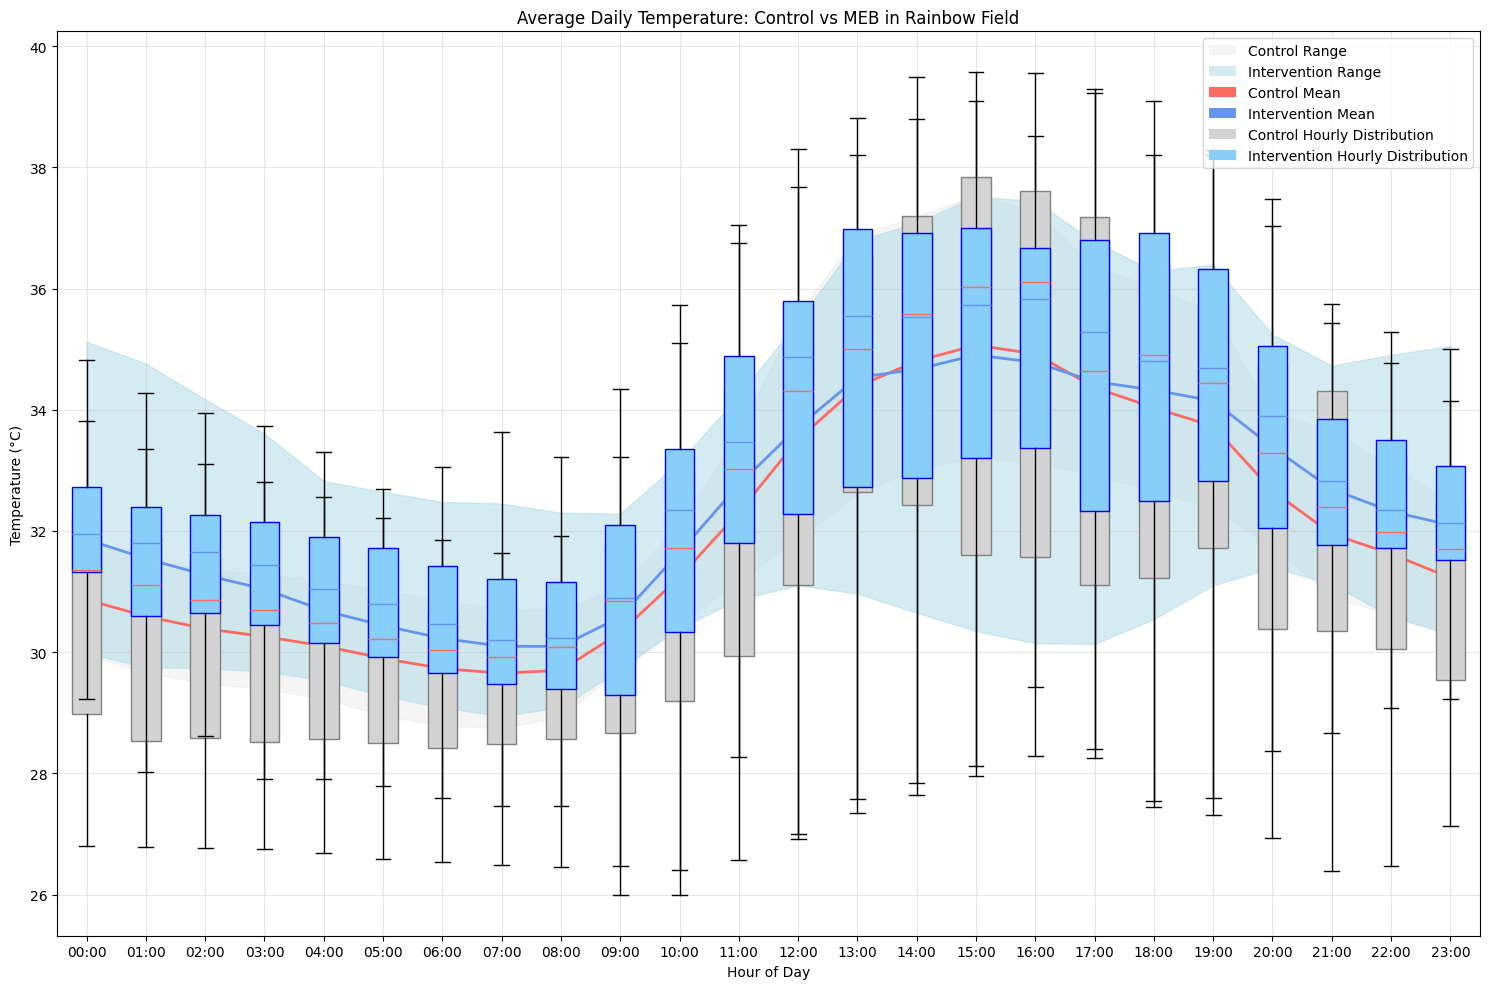

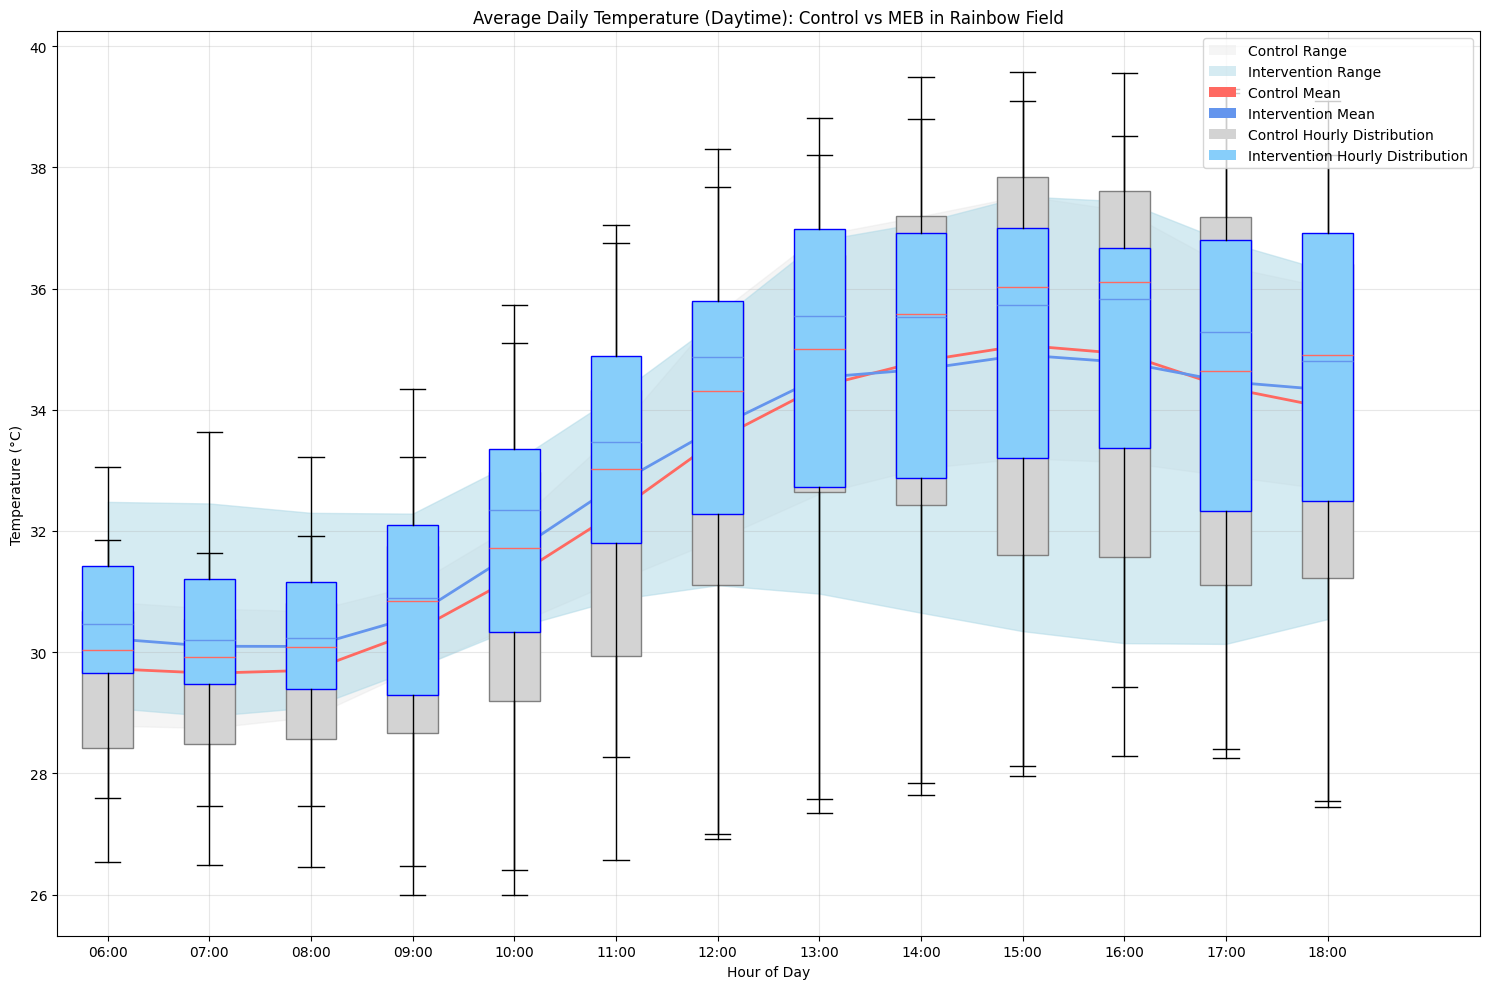

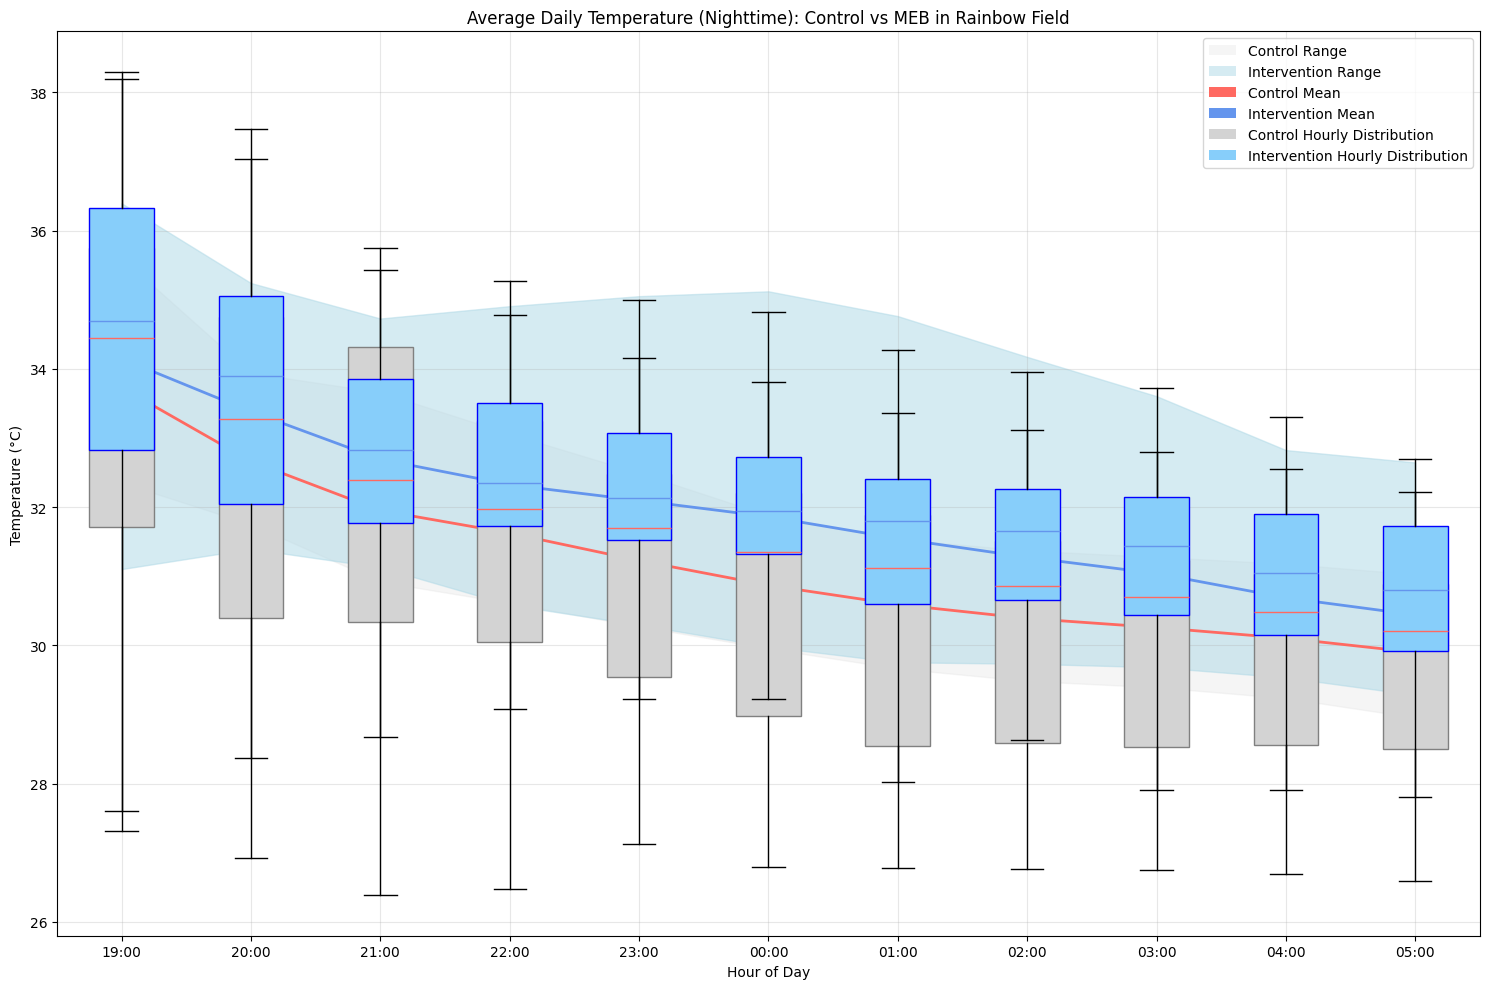

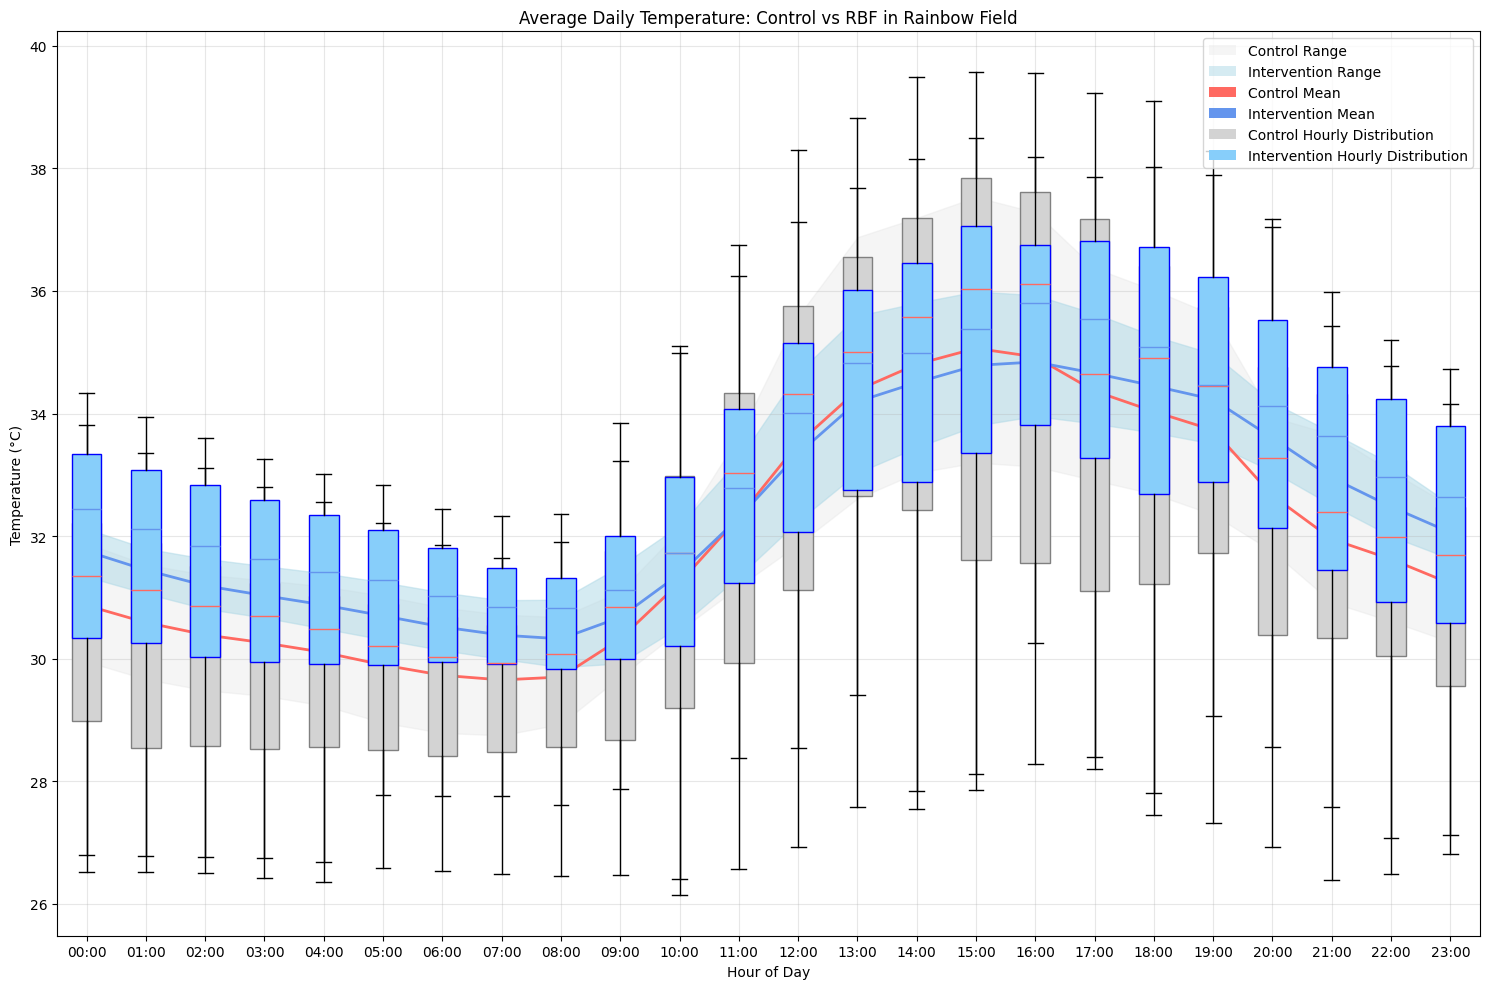

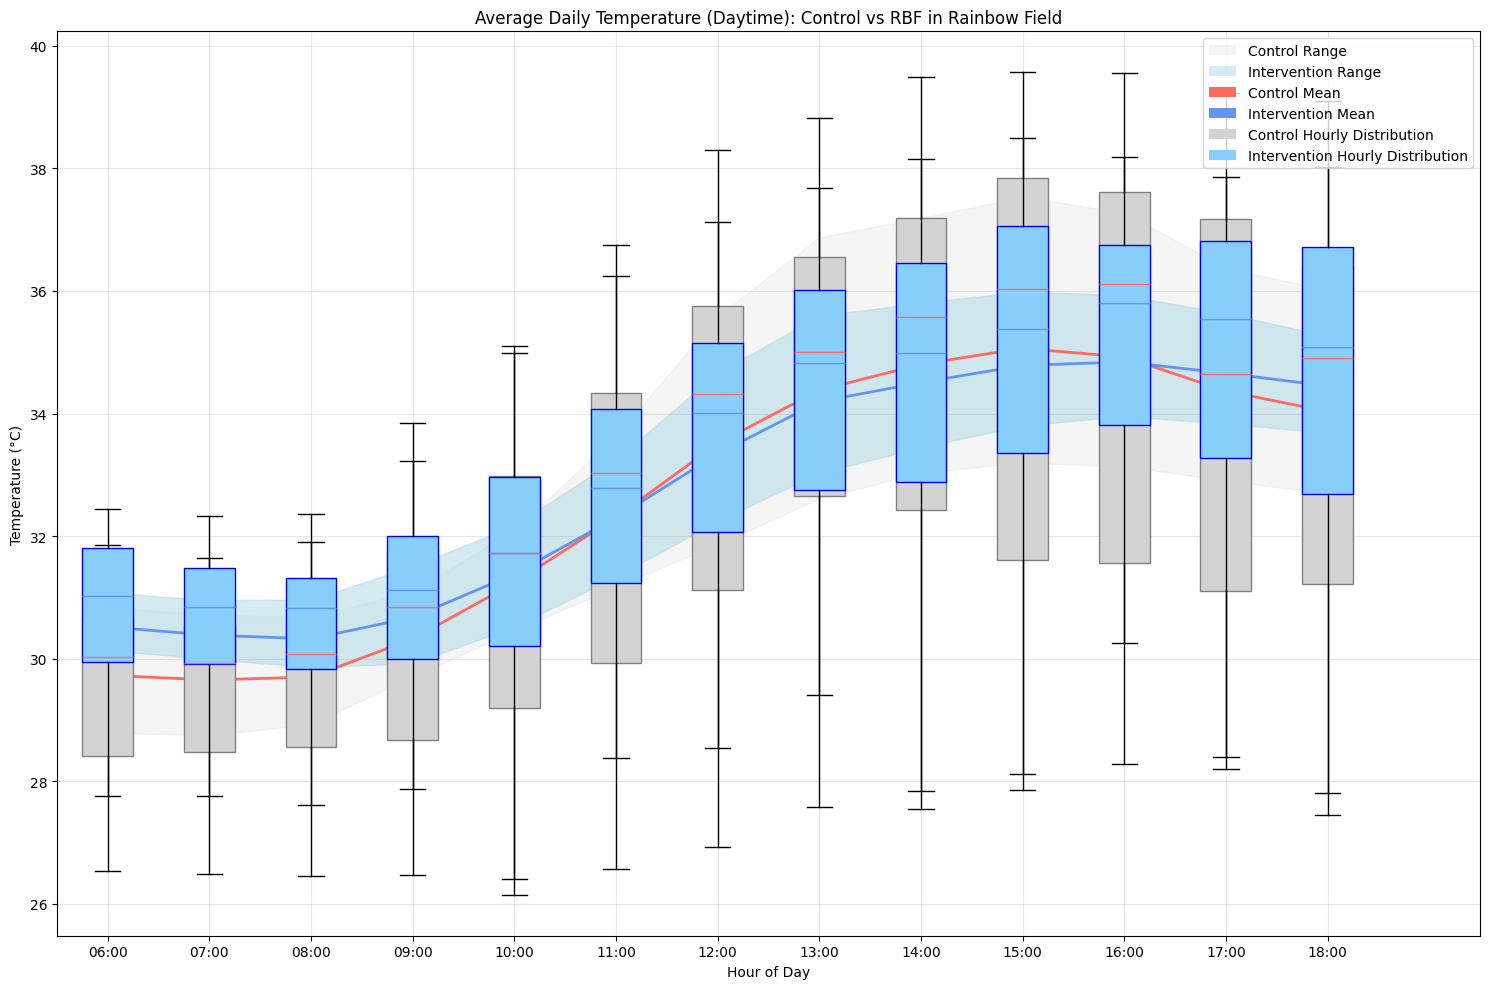

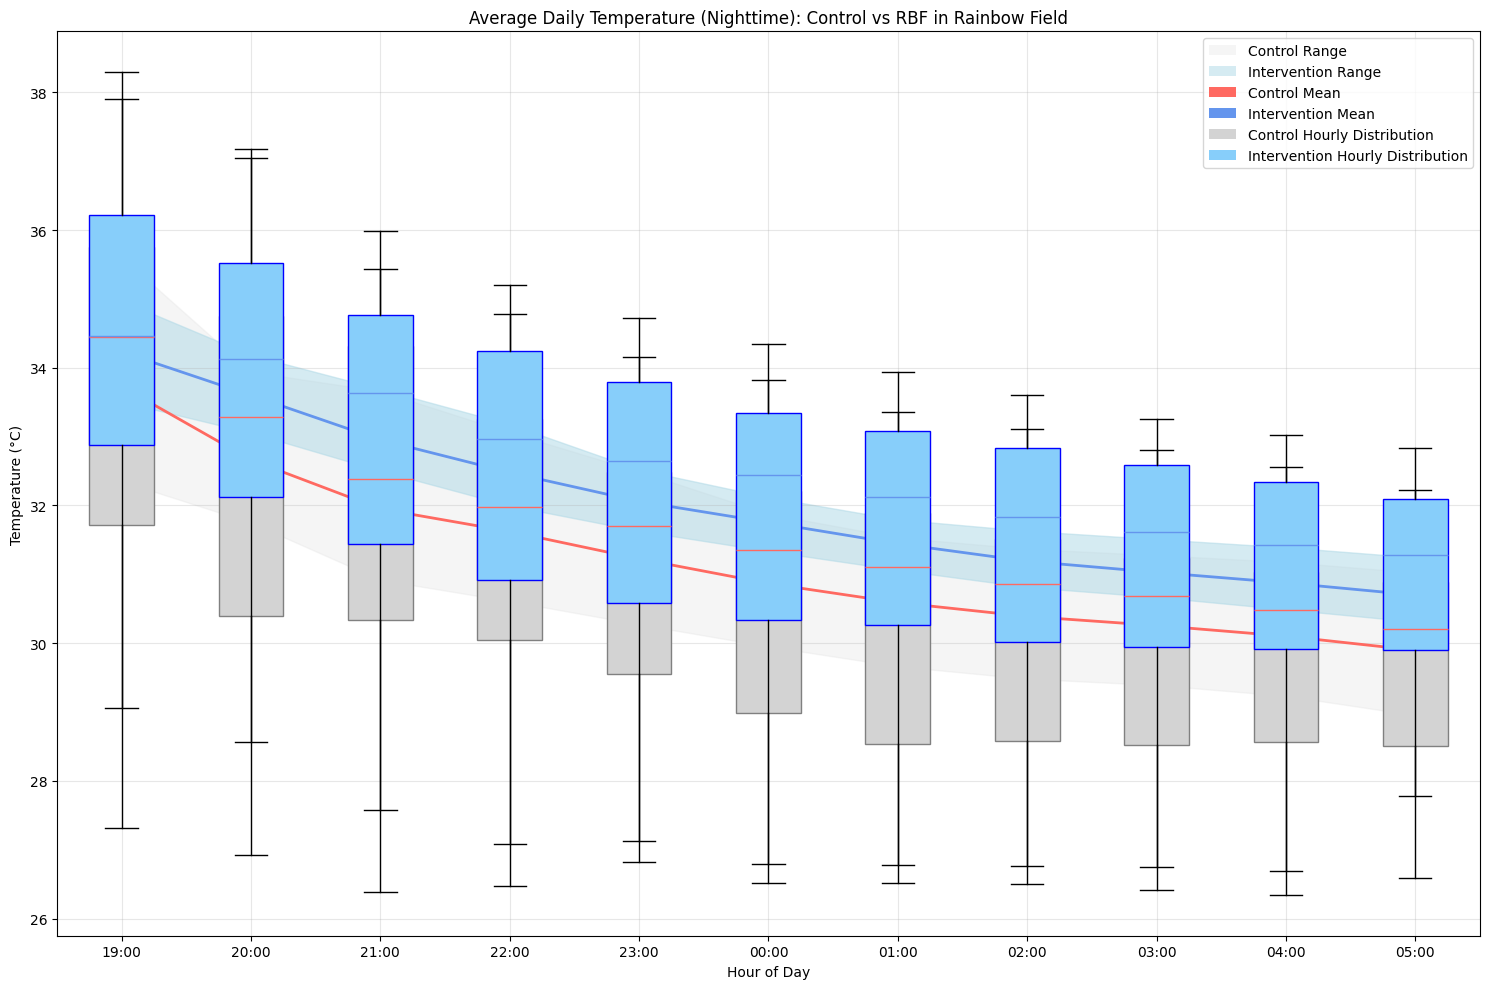

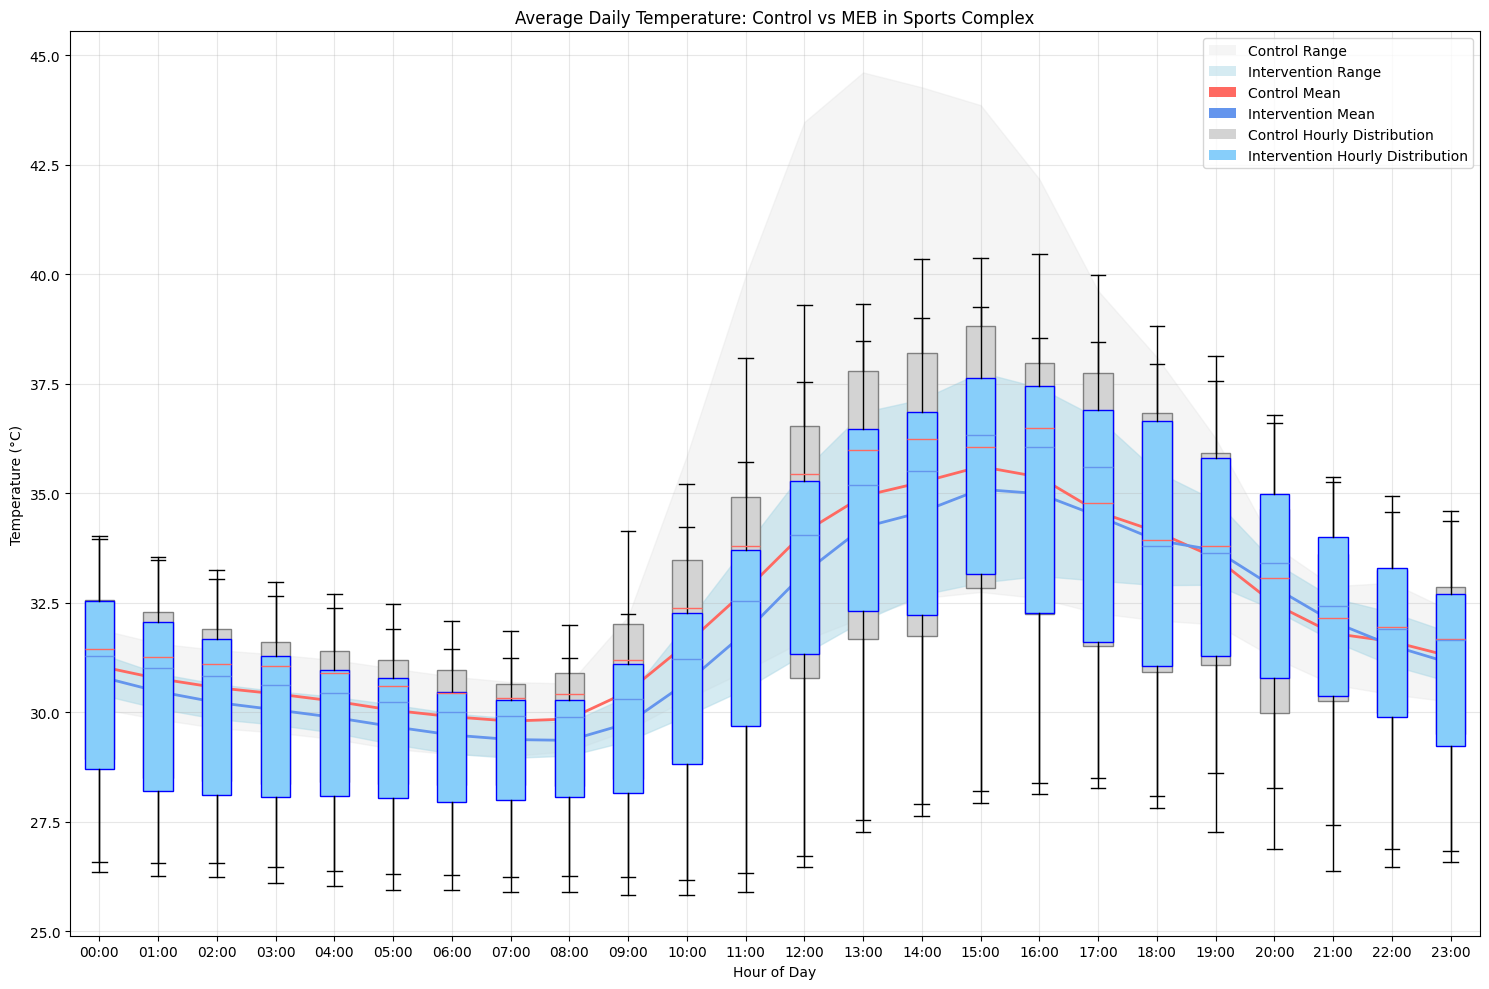

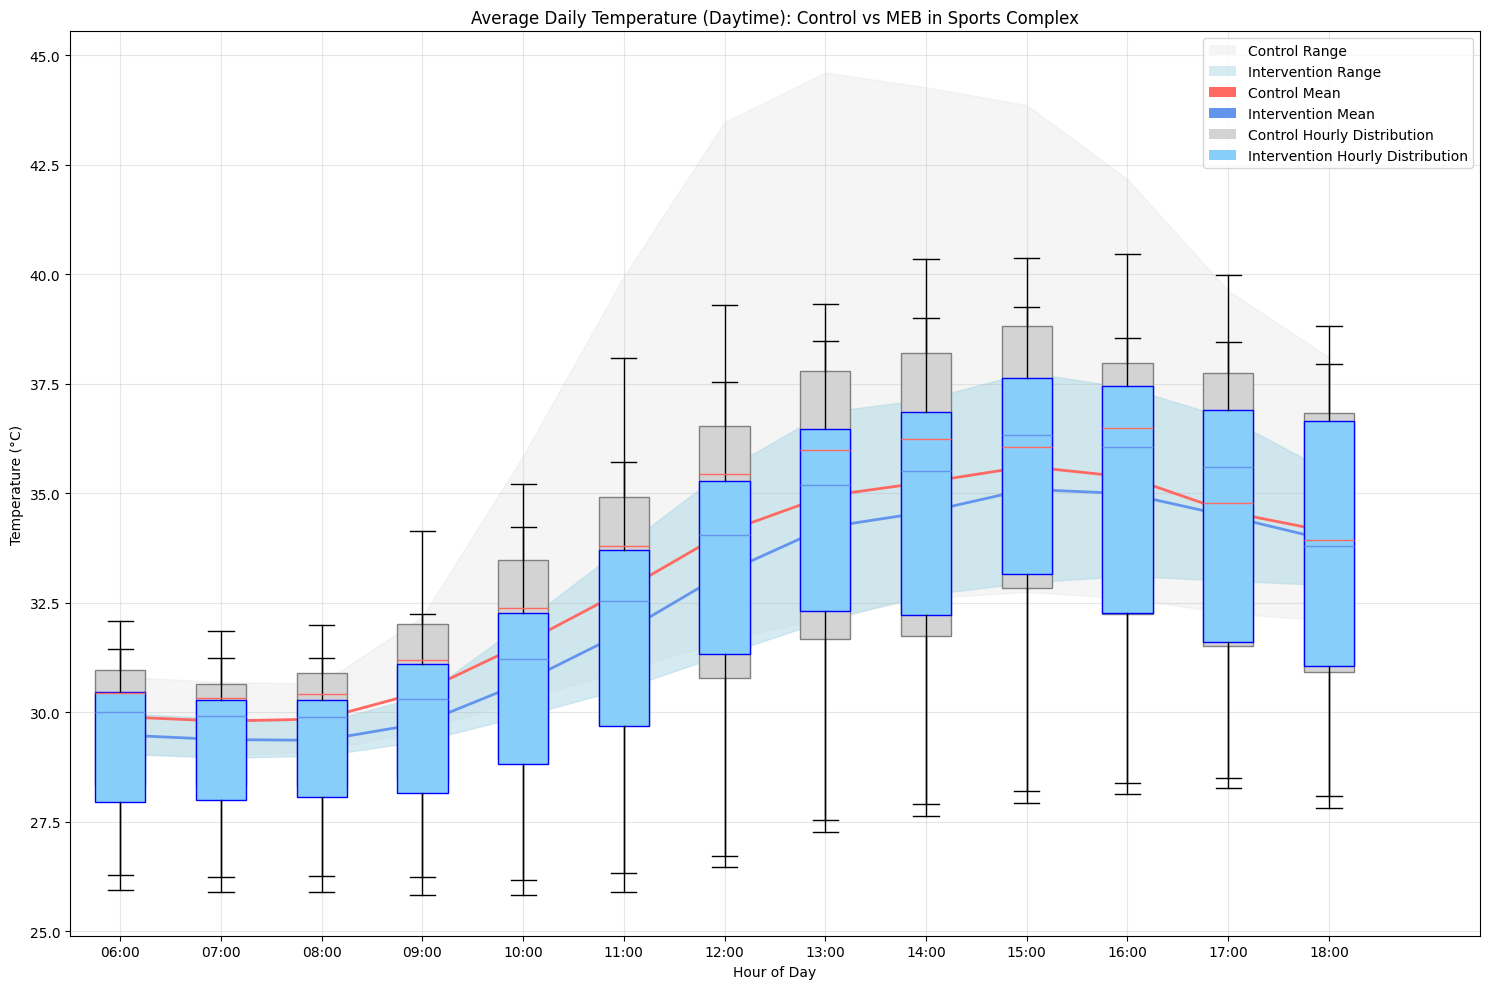

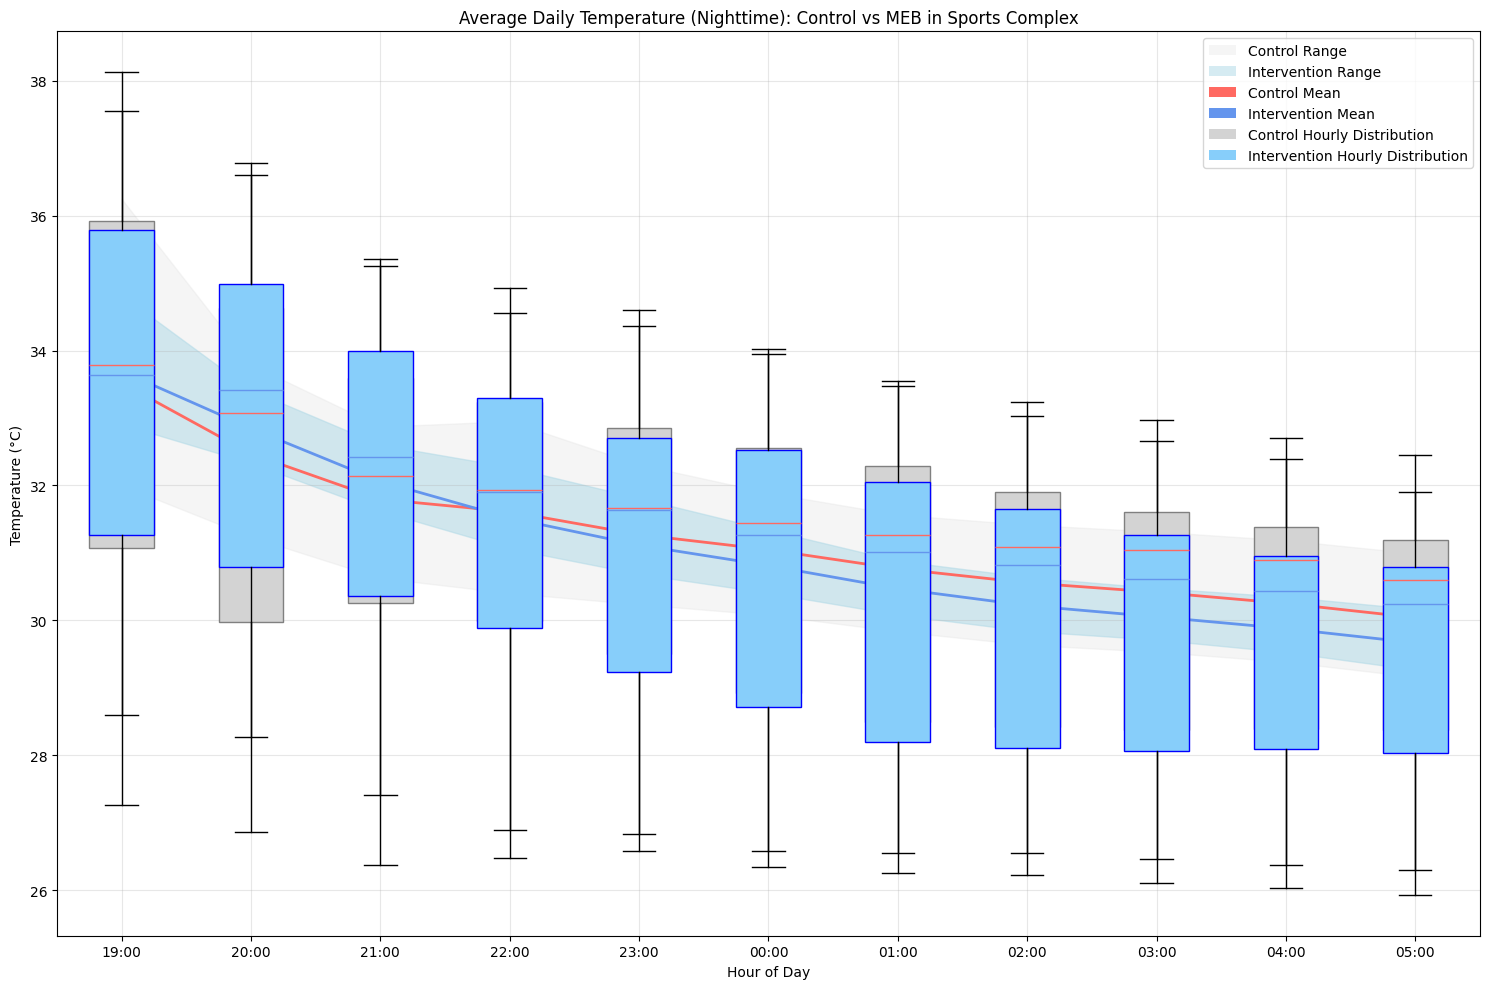

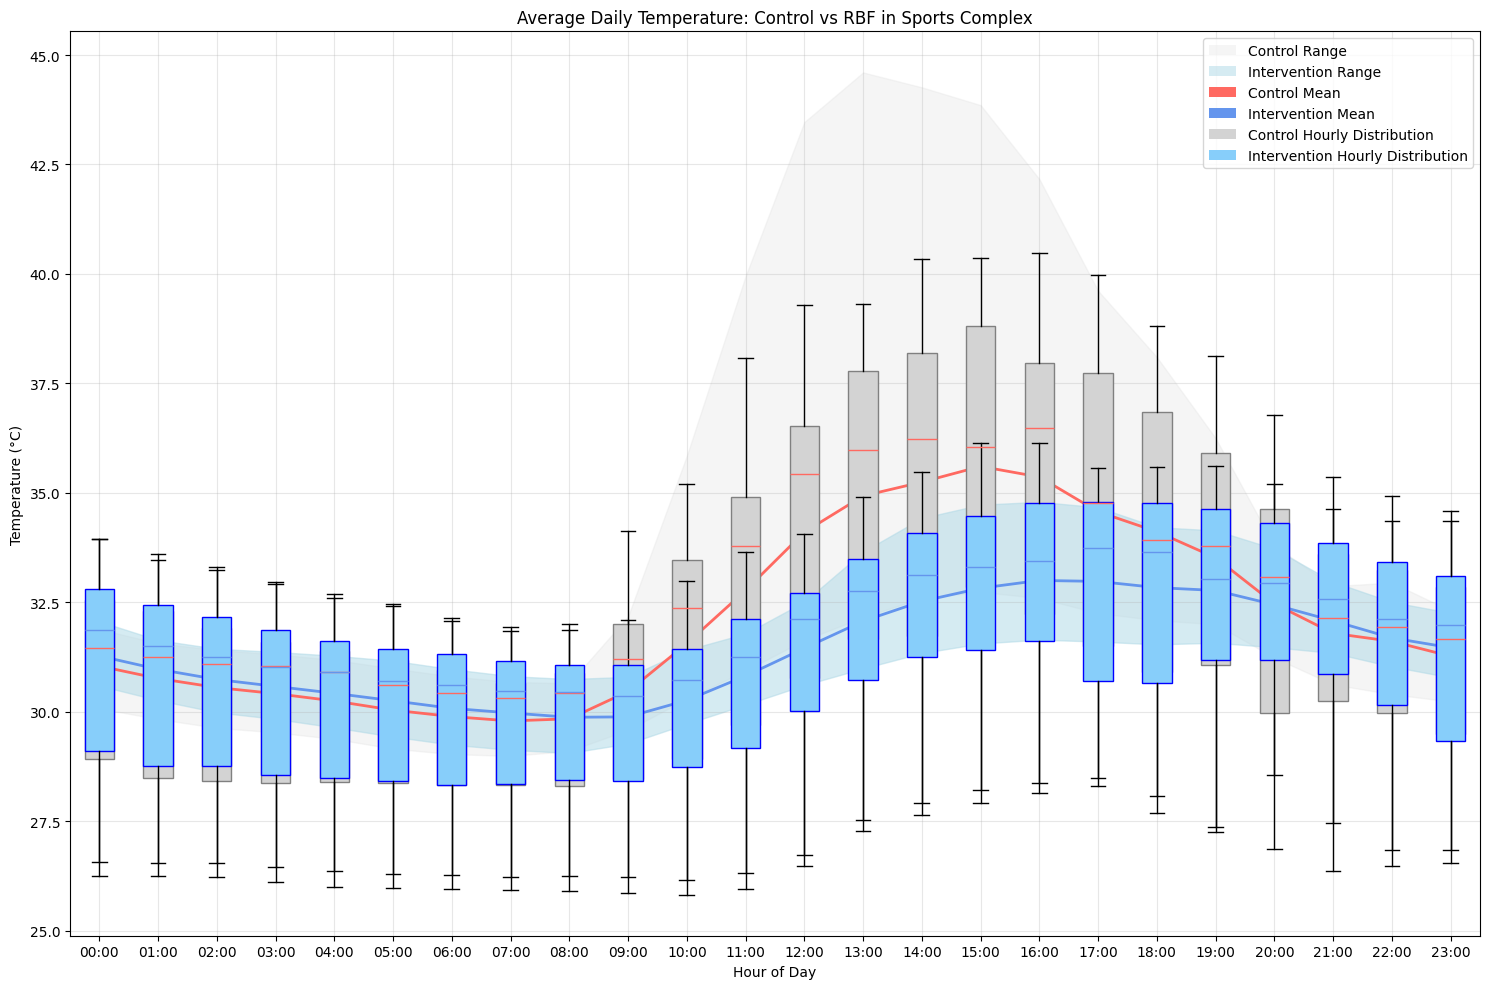

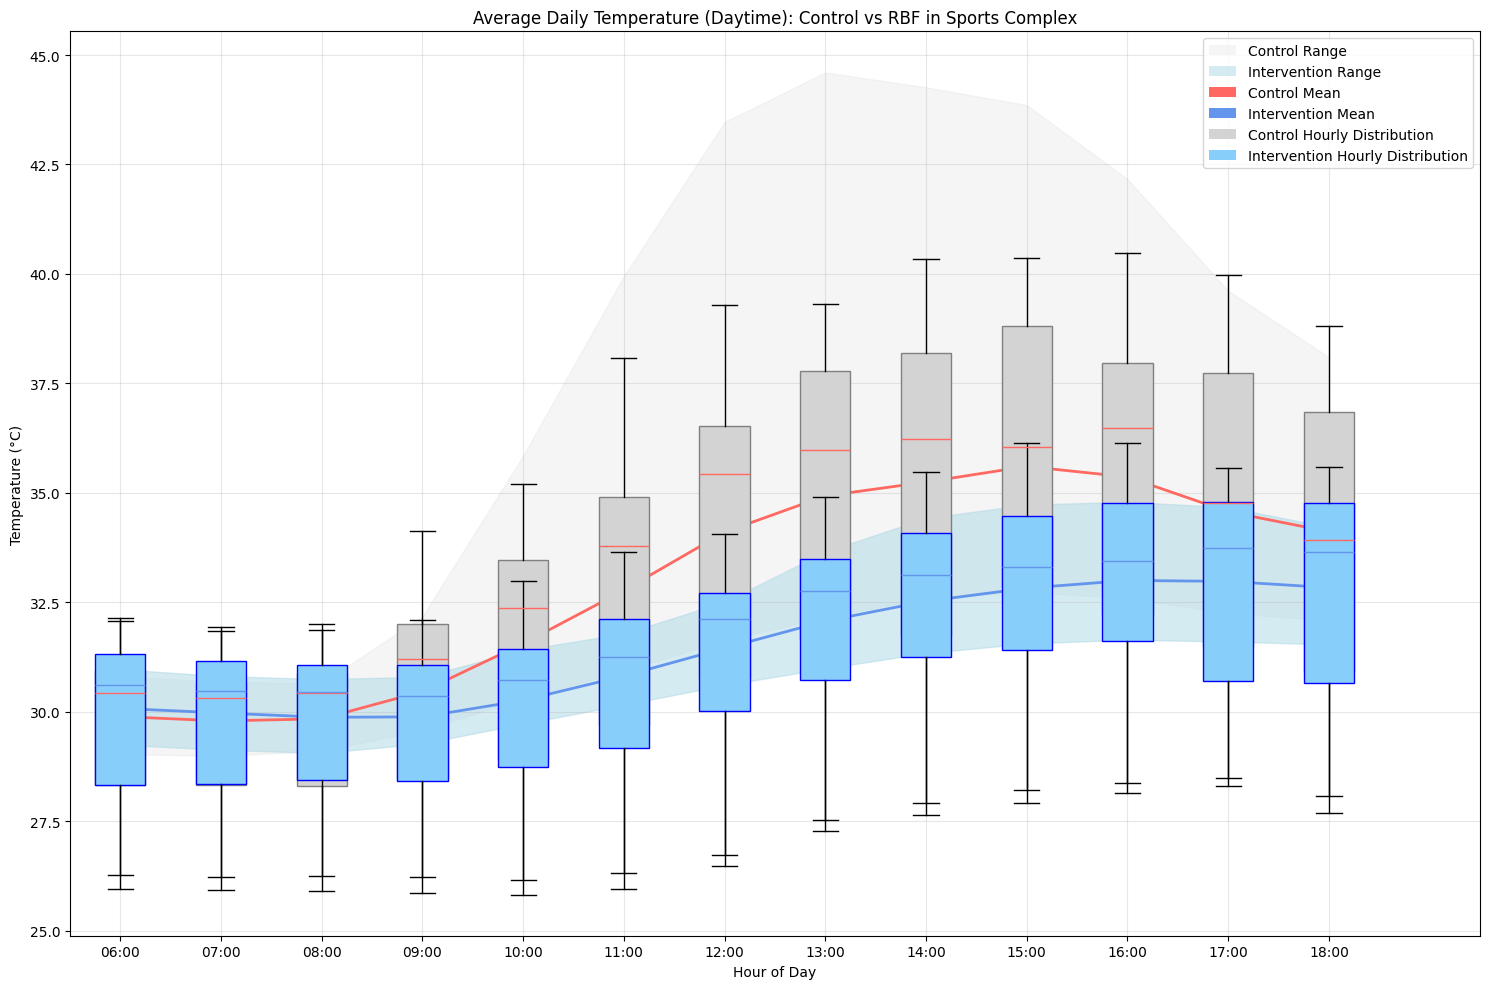

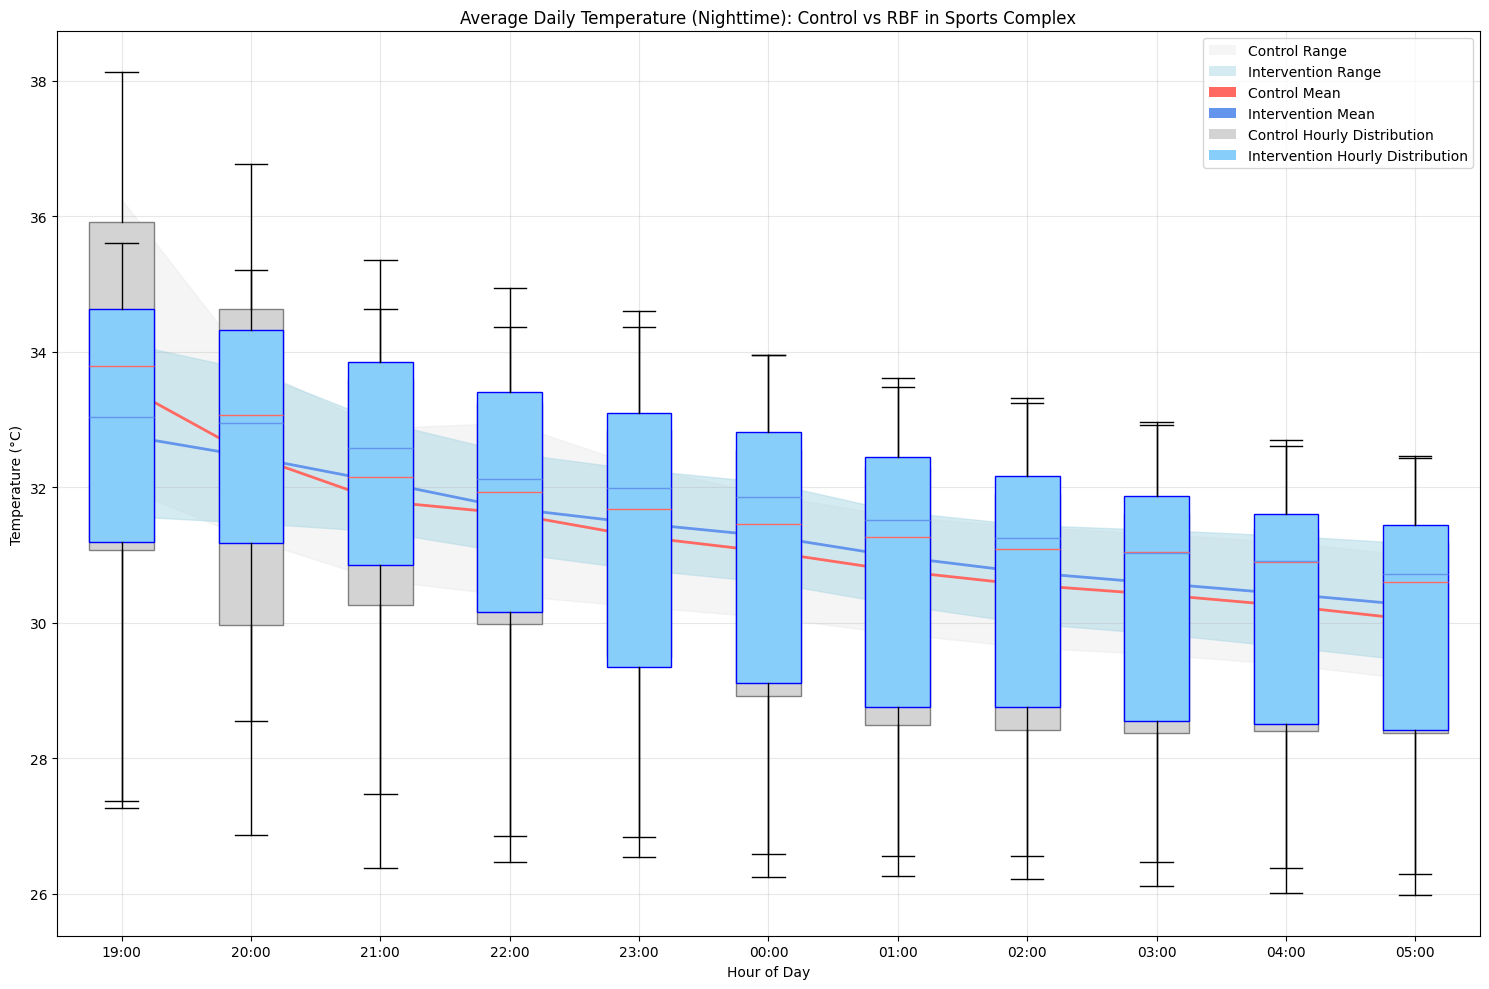

In [3]:
import pandas as pd
import numpy.ma as ma
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

def create_average_day_comparison_plot(
    settlement, 
    intervention_type='MEB',
    period='Full',  # 'Full', 'Day', or 'Night'
    colors=None
):
    """
    Create comparison plot of temperatures for an average 24-hour day
    
    Parameters:
    -----------
    settlement : str
        Name of the settlement
    intervention_type : str
        Type of intervention (default: 'MEB')
    period : str
        Time period to plot ('Full', 'Day', or 'Night')
    colors : dict, optional
        Dictionary to customize plot colors
    """
    default_colors = {
        'control_range': '#E0E0E0',
        'intervention_range': '#ADD8E6',
        'control_mean': '#FF6961',
        'intervention_mean': '#6495ED',
        'control_box': '#D3D3D3',
        'intervention_box': '#87CEFA'
    }
    
    if colors is not None:
        default_colors.update(colors)
    
    # Load data
    master_df = pd.read_csv('master_dataframe.csv', parse_dates=['DateTime'])
    logger_flags_df = pd.read_csv('logger_flags.csv')
    
    # Get loggers
    control_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) & 
        (logger_flags_df['Intervention'] == 'CONTROL')
    ]['Loggers'].tolist()
    
    intervention_loggers = logger_flags_df[
        (logger_flags_df['Settlement'] == settlement) & 
        (logger_flags_df['Intervention'] == intervention_type)
    ]['Loggers'].tolist()
    
    intervention_start = pd.to_datetime(
        logger_flags_df[
            (logger_flags_df['Settlement'] == settlement) & 
            (logger_flags_df['Intervention'] == intervention_type)
        ]['Intervention_Start'].iloc[0]
    )
    
    # Process data
    master_df['DateTime'] = pd.to_datetime(master_df['DateTime'])
    post_intervention_df = master_df[master_df['DateTime'] >= intervention_start].copy()
    post_intervention_df['Hour'] = post_intervention_df['DateTime'].dt.hour
    
    # Define hours range based on period
    if period == 'Day':
        post_intervention_df = post_intervention_df[
            (post_intervention_df['Hour'] >= 6) & 
            (post_intervention_df['Hour'] < 19)
        ]
        hours_range = range(6, 19)
    elif period == 'Night':
        post_intervention_df = post_intervention_df[
            (post_intervention_df['Hour'] < 6) | 
            (post_intervention_df['Hour'] >= 19)
        ]
        evening_hours = list(range(19, 24))
        morning_hours = list(range(0, 6))
        hours_range = evening_hours + morning_hours
    else:  # Full day
        hours_range = range(24)
    
    def calculate_hourly_stats(loggers, df):
        hourly_stats = []
        
        for hour in hours_range:
            hour_data = df[df['Hour'] == hour][loggers]
            hour_data = hour_data.replace(0, np.nan)
            hour_data = hour_data.dropna(how='all')
            
            if not hour_data.empty:
                stats = {
                    'Hour': hour,
                    'plot_hour': hour if period != 'Night' else (hour if hour >= 19 else hour + 24),
                    'max': hour_data.max(axis=1).mean(),
                    'min': hour_data.min(axis=1).mean(),
                    'mean': hour_data.mean(axis=1).mean(),
                    'std': hour_data.mean(axis=1).std(),
                    'values': hour_data.mean(axis=1).values
                }
                hourly_stats.append(stats)
        
        return pd.DataFrame(hourly_stats)
    
    control_stats = calculate_hourly_stats(control_loggers, post_intervention_df)
    intervention_stats = calculate_hourly_stats(intervention_loggers, post_intervention_df)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Plot ranges using plot_hour instead of Hour for night period
    x_values = control_stats['plot_hour'] if period == 'Night' else control_stats['Hour']
    
    control_range = ax.fill_between(x_values,
                                  control_stats['max'],
                                  control_stats['min'],
                                  alpha=0.3,
                                  color=default_colors['control_range'],
                                  label='Control Range')
    
    x_values = intervention_stats['plot_hour'] if period == 'Night' else intervention_stats['Hour']
    
    intervention_range = ax.fill_between(x_values,
                                       intervention_stats['max'],
                                       intervention_stats['min'],
                                       alpha=0.5,
                                       color=default_colors['intervention_range'],
                                       label='Intervention Range')
    
    # Plot mean lines
    x_values = control_stats['plot_hour'] if period == 'Night' else control_stats['Hour']
    control_mean, = ax.plot(x_values,
                          control_stats['mean'],
                          color=default_colors['control_mean'],
                          label='Control Mean',
                          linewidth=2)
    
    x_values = intervention_stats['plot_hour'] if period == 'Night' else intervention_stats['Hour']
    intervention_mean, = ax.plot(x_values,
                               intervention_stats['mean'],
                               color=default_colors['intervention_mean'],
                               label='Intervention Mean',
                               linewidth=2)
    
    # Create box plots
    control_boxes = []
    intervention_boxes = []
    
    for _, row in control_stats.iterrows():
        x_pos = row['plot_hour'] if period == 'Night' else row['Hour']
        control_box = ax.boxplot(row['values'],
                               positions=[x_pos],
                               widths=0.5,
                               patch_artist=True,
                               boxprops=dict(facecolor=default_colors['control_box'], color='gray'),
                               medianprops=dict(color=default_colors['control_mean']),
                               showfliers=False)
        control_boxes.append(control_box)
    
    for _, row in intervention_stats.iterrows():
        x_pos = row['plot_hour'] if period == 'Night' else row['Hour']
        intervention_box = ax.boxplot(row['values'],
                                    positions=[x_pos],
                                    widths=0.5,
                                    patch_artist=True,
                                    boxprops=dict(facecolor=default_colors['intervention_box'], color='blue'),
                                    medianprops=dict(color=default_colors['intervention_mean']),
                                    showfliers=False)
        intervention_boxes.append(intervention_box)
    
    # Create legend
    legend_elements = [
        (Patch(facecolor=default_colors['control_range'], alpha=0.3), [control_range], 'Control Range'),
        (Patch(facecolor=default_colors['intervention_range'], alpha=0.5), [intervention_range], 'Intervention Range'),
        (Patch(facecolor=default_colors['control_mean']), [control_mean], 'Control Mean'),
        (Patch(facecolor=default_colors['intervention_mean']), [intervention_mean], 'Intervention Mean'),
        (Patch(facecolor=default_colors['control_box'], alpha=1.0), 
         control_boxes, 
         'Control Hourly Distribution'),
        (Patch(facecolor=default_colors['intervention_box'], alpha=1.0), 
         intervention_boxes, 
         'Intervention Hourly Distribution')
    ]
    
    leg = ax.legend([item[0] for item in legend_elements],
                   [item[2] for item in legend_elements],
                   loc='upper right')
    
    # Interactive legend
    lined = {}
    for legpatch, elements, label in legend_elements:
        legline = leg.get_patches()[legend_elements.index((legpatch, elements, label))]
        if 'Distribution' in label:
            lined[legline] = elements
        else:
            lined[legline] = elements
    
    def on_pick(event):
        legline = event.artist
        if legline in lined:
            elements = lined[legline]
            
            if isinstance(elements[0], dict): 
                visible = not any(box['boxes'][0].get_visible() for box in elements)
                for box in elements:
                    for component in box.values():
                        for artist in component:
                            artist.set_visible(visible)
            else:
                visible = not elements[0].get_visible()
                for element in elements:
                    element.set_visible(visible)
            
            legline.set_alpha(1.0 if visible else 0.2)
            fig.canvas.draw()
    
    for legline in leg.get_patches():
        legline.set_picker(True)
    fig.canvas.mpl_connect('pick_event', on_pick)
    
    # Set labels and title
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Temperature (°C)')
    period_str = f" ({period}time)" if period != 'Full' else ""
    ax.set_title(f'Average Daily Temperature{period_str}: Control vs {intervention_type} in {settlement}')
    
    # Set x-axis ticks and limits based on period
    if period == 'Night':
        plot_hours = list(range(19, 24)) + list(range(24, 30))  # 19-23 and 24-29 (0-5)
        ax.set_xticks(plot_hours)
        hour_labels = [f'{h:02d}:00' if h < 24 else f'{h-24:02d}:00' for h in plot_hours]
        ax.set_xticklabels(hour_labels)
        ax.set_xlim(18.5, 29.5)
    elif period == 'Day':
        ax.set_xticks(list(hours_range))
        ax.set_xticklabels([f'{hour:02d}:00' for hour in hours_range])
        ax.set_xlim(5.5, 19.5)
    else:  # Full day
        ax.set_xticks(list(hours_range))
        ax.set_xticklabels([f'{hour:02d}:00' for hour in hours_range])
        ax.set_xlim(-0.5, 23.5)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Settings
settlements = ['Rainbow Field', 'Sports Complex']
intervention_types = ['MEB', 'RBF']
periods = ['Full', 'Day', 'Night']
custom_colors = {
    'control_range': '#E0E0E0',  # Light gray
    'intervention_range': '#ADD8E6',  # Light blue
    'control_mean': '#FF6961',  # Soft red
    'intervention_mean': '#6495ED',  # Cornflower blue
    'control_box': '#D3D3D3',  # Light gray
    'intervention_box': '#87CEFA'  # Light sky blue
}

# Generate all plots
for settlement in settlements:
    for intervention_type in intervention_types:
        for period in periods:
            create_average_day_comparison_plot(
                settlement, 
                intervention_type,
                period,
                colors=custom_colors
            )